# Spike Time Dependent Plasticity
## Basic Experiments

In this notebook I'm going to implement some basic experiments related to the STDP algorithm from scratch.

The outline for this notebook is the following:
- Import all the modules:
    - inlcuded the other script with all the functions and the classes needed
- Simple neurons models:
    - LIF neuron 
    - Poisson Neuron Model
- STDP algorithms
    - general simulation
    - STDP rule
- Turn the screw on STDP
    - Spike time shifted correlateds trains
    - ...

In [3]:
%load_ext autoreload
%autoreload 2
# basic libraries
import os
import sys
import shutil
import time
import numpy as np
import pandas as pd

# graphics libraries
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import jupyterlab_widgets as lab
from IPython.display import display
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format='retina'
# use NMA plot style
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
plt.style.use('seaborn-v0_8')
my_layout = widgets.Layout()
my_layout.width = '620px'

#import from my scripts
main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)
import importlib

importlib.reload(importlib.import_module('neurons'))
importlib.reload(importlib.import_module('learning_rules'))
importlib.reload(importlib.import_module('plot_utils'))
importlib.reload(importlib.import_module('experiments'))
from neurons import *
from learning_rules import *
from plot_utils import *
from experiments import *


# show packages versions for python, numpy, and ipywidgets
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("jupyterlab_widgets: ", lab.__version__ )
print("IPywidgets: ", widgets.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Numpy:  1.26.0
Pandas:  2.1.1
jupyterlab_widgets:  3.0.9
IPywidgets:  8.0.4


# Simple Neuron Models

I'll start implementing the neurons as python functions, therefore I'll move to class syntax. 

## LIF neuron

We can see the overall raster plot.

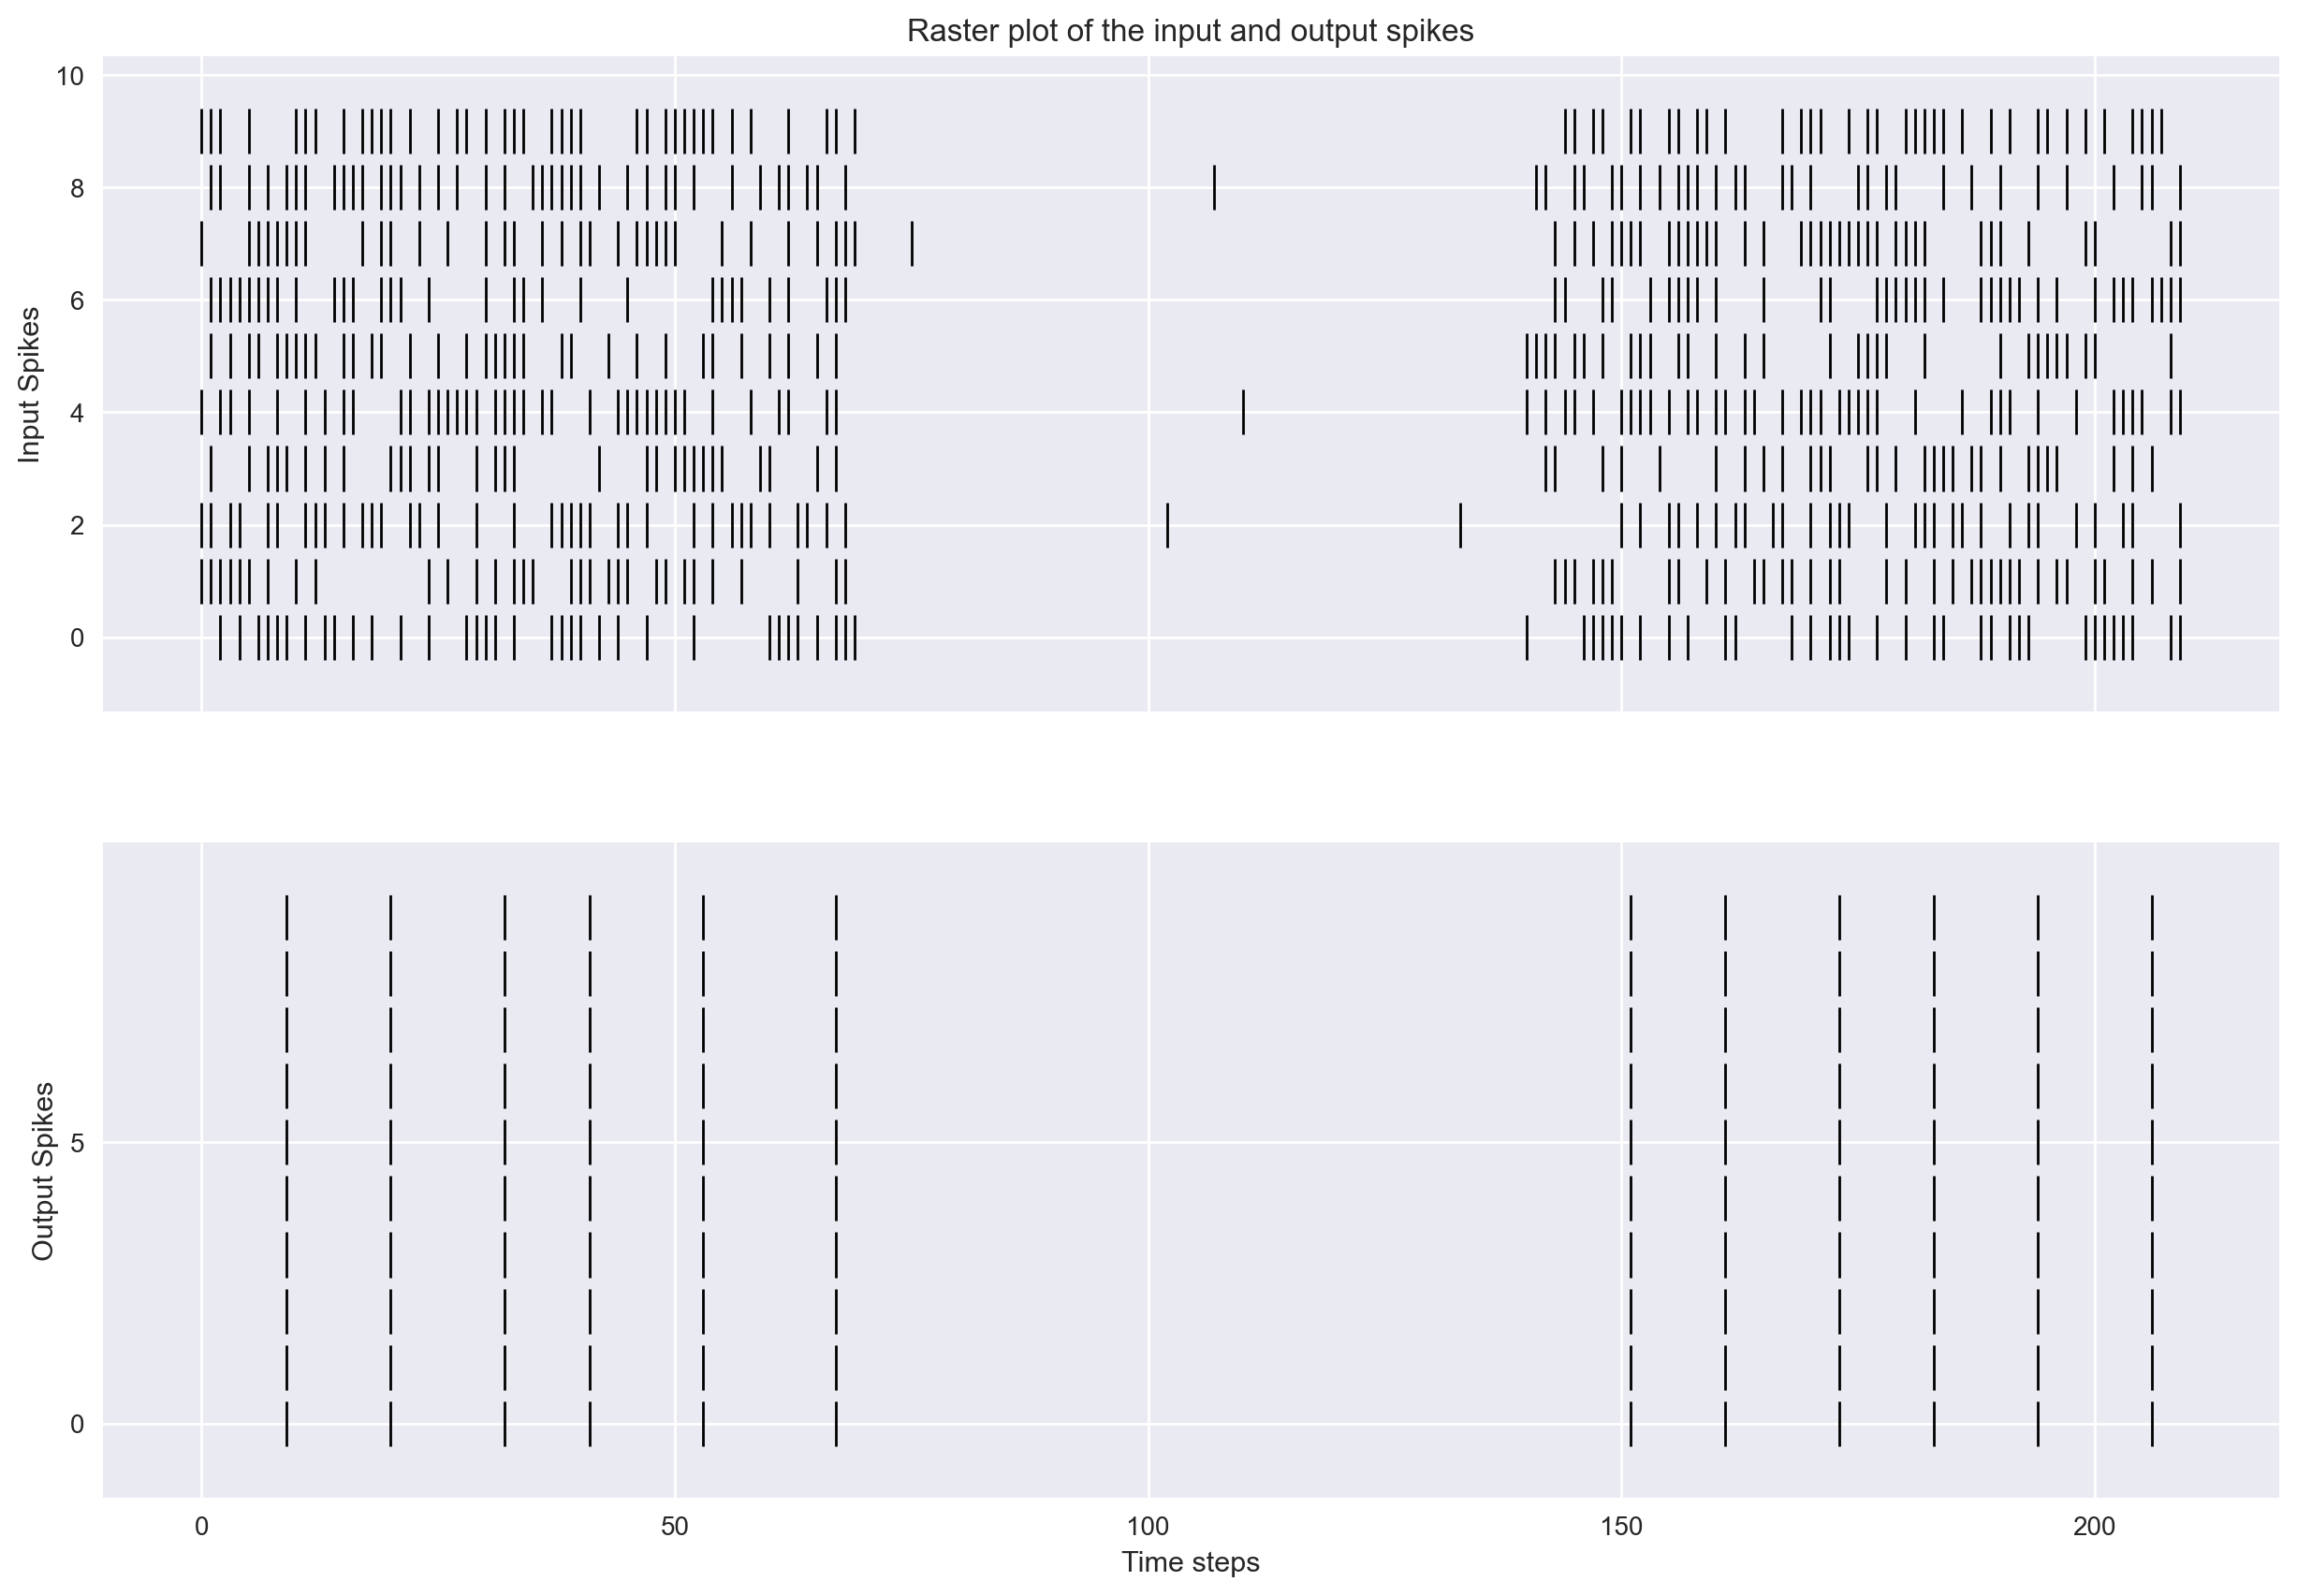

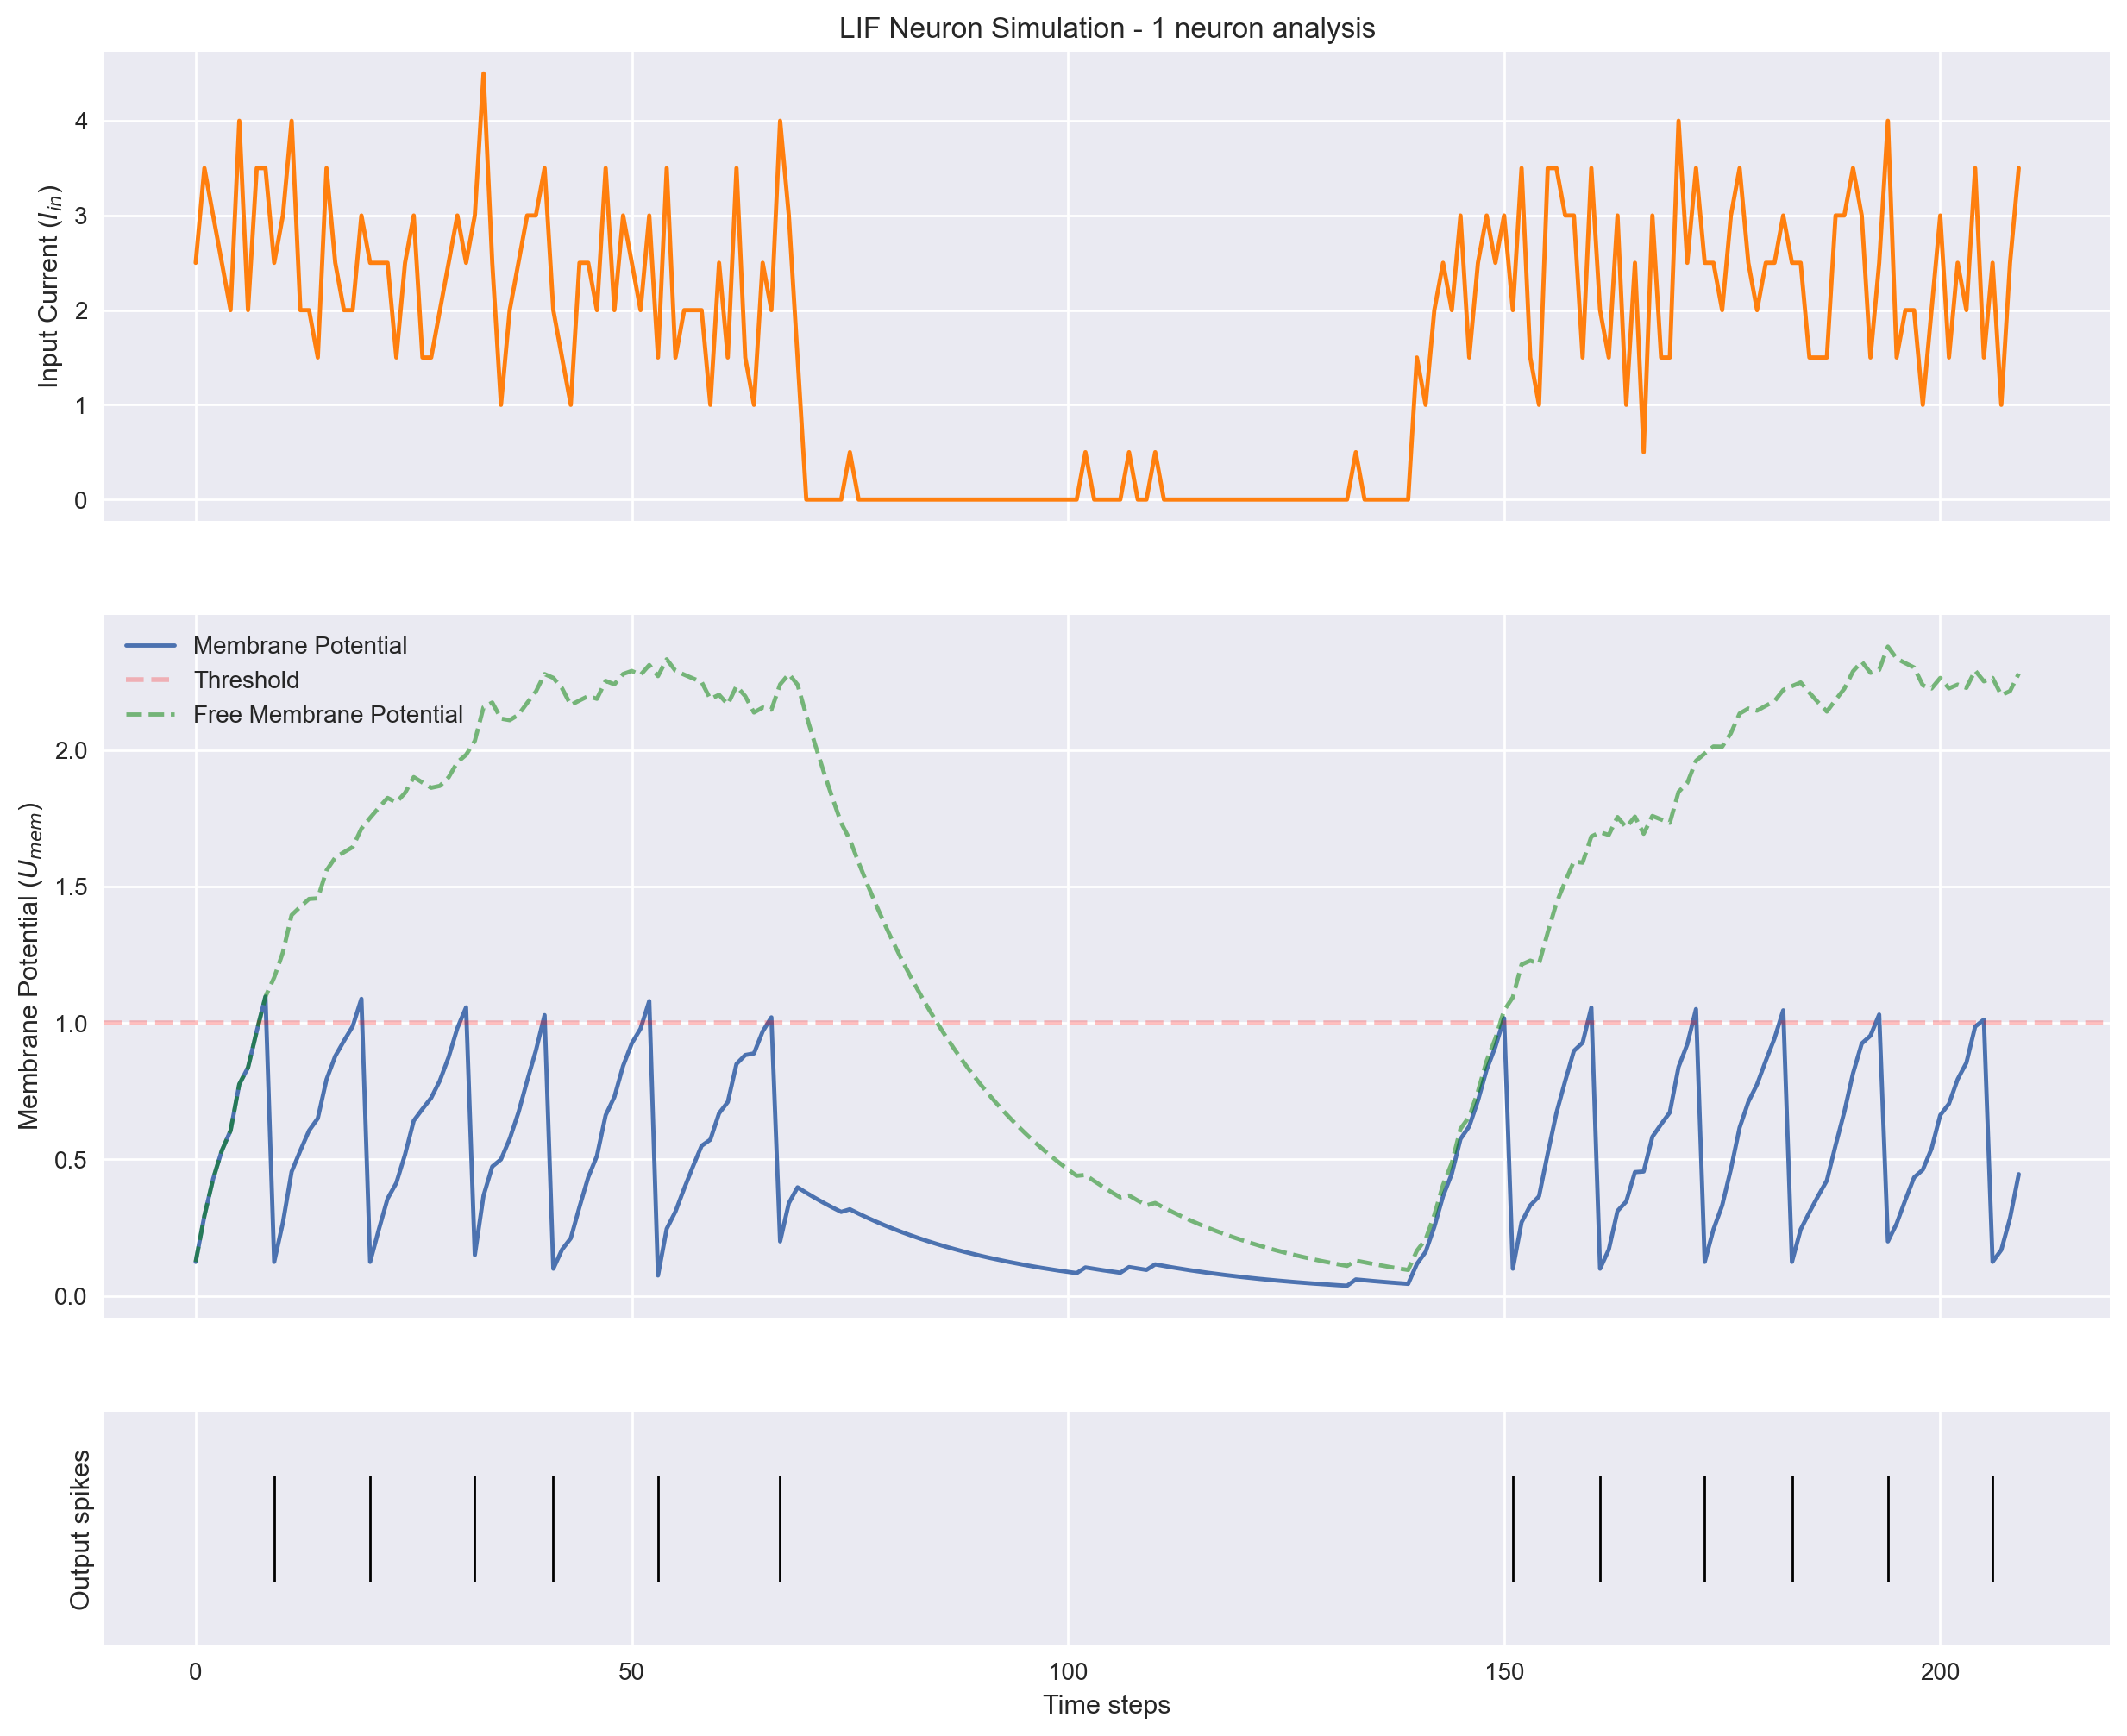

In [2]:
N_pre = 10
N_post = 10
num_steps = 210 

# example of pre-synaptic spike trains
I = np.concatenate([np.round(np.random.random((num_steps//3,N_pre))), np.round(np.random.random((num_steps//3,N_pre))-0.49),np.round(np.random.random((num_steps//3,N_pre)))], axis=0) 


pars = default_pars(tau_m=20,
                    refractory_time = False, 
                    dynamic_threshold = False, 
                    hard_reset = True
                    )
# run the base simulation
lif = simulation(pars, I, N_post = N_post, W_init = weight_initializer(pars, N_post, I=I))

get_post_spk_trains = lambda neuron_list : np.array([neuron_list[i].get_records()['spk'] for i in range(len(neuron_list))]).T

raster_plot(pars, pre_syn_spk=I, post_syn_spk=get_post_spk_trains(lif), title = 'Raster plot of the input and output spikes')

lif[0].plot_records(title="LIF Neuron Simulation - 1 neuron analysis", show_fmp=True)

In [3]:
N_pre = 2
N_post = 1
num_steps = 2000

interactive_lif = LIF_interactive_plot(default_pars, N_pre, num_steps,
                         type_parameters = 'simple',
                         N_post = N_post,
                         post_index = 0,
                         manual_update = True, 
                         time_in_ms = False,
                         my_seed = 2024,
                        )

display(interactive_lif)

## LIF neuron model with conductance based input

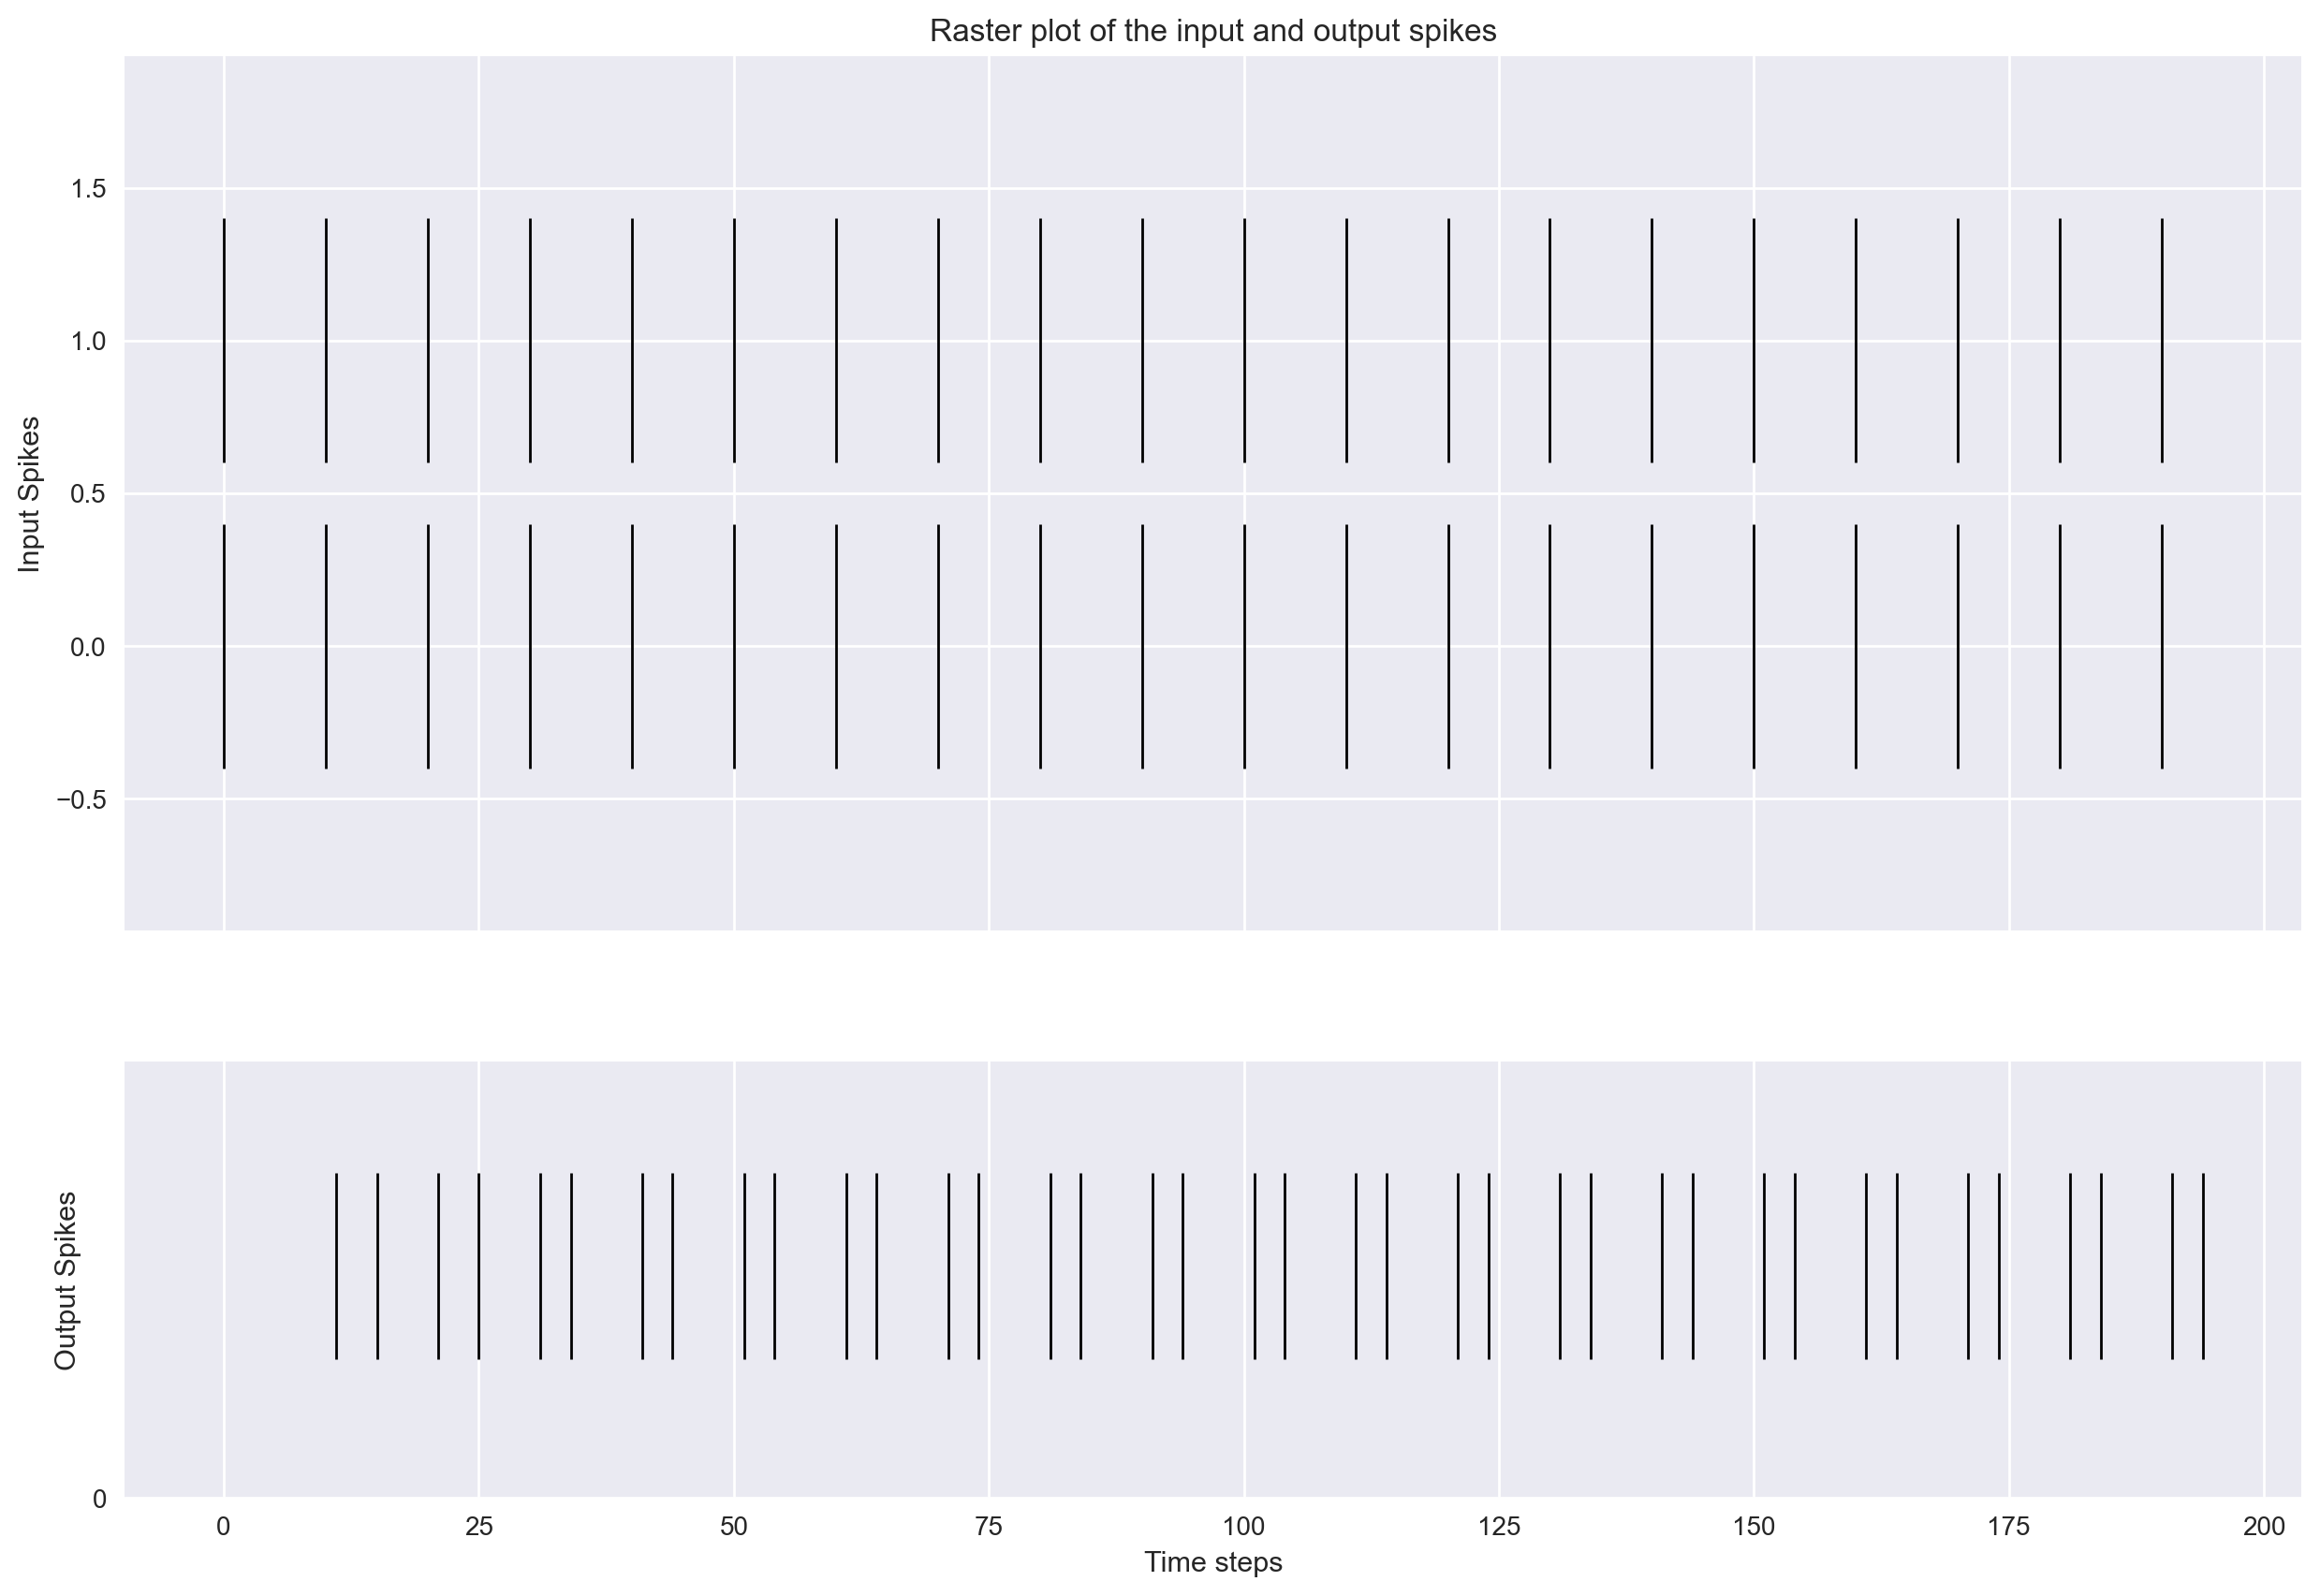

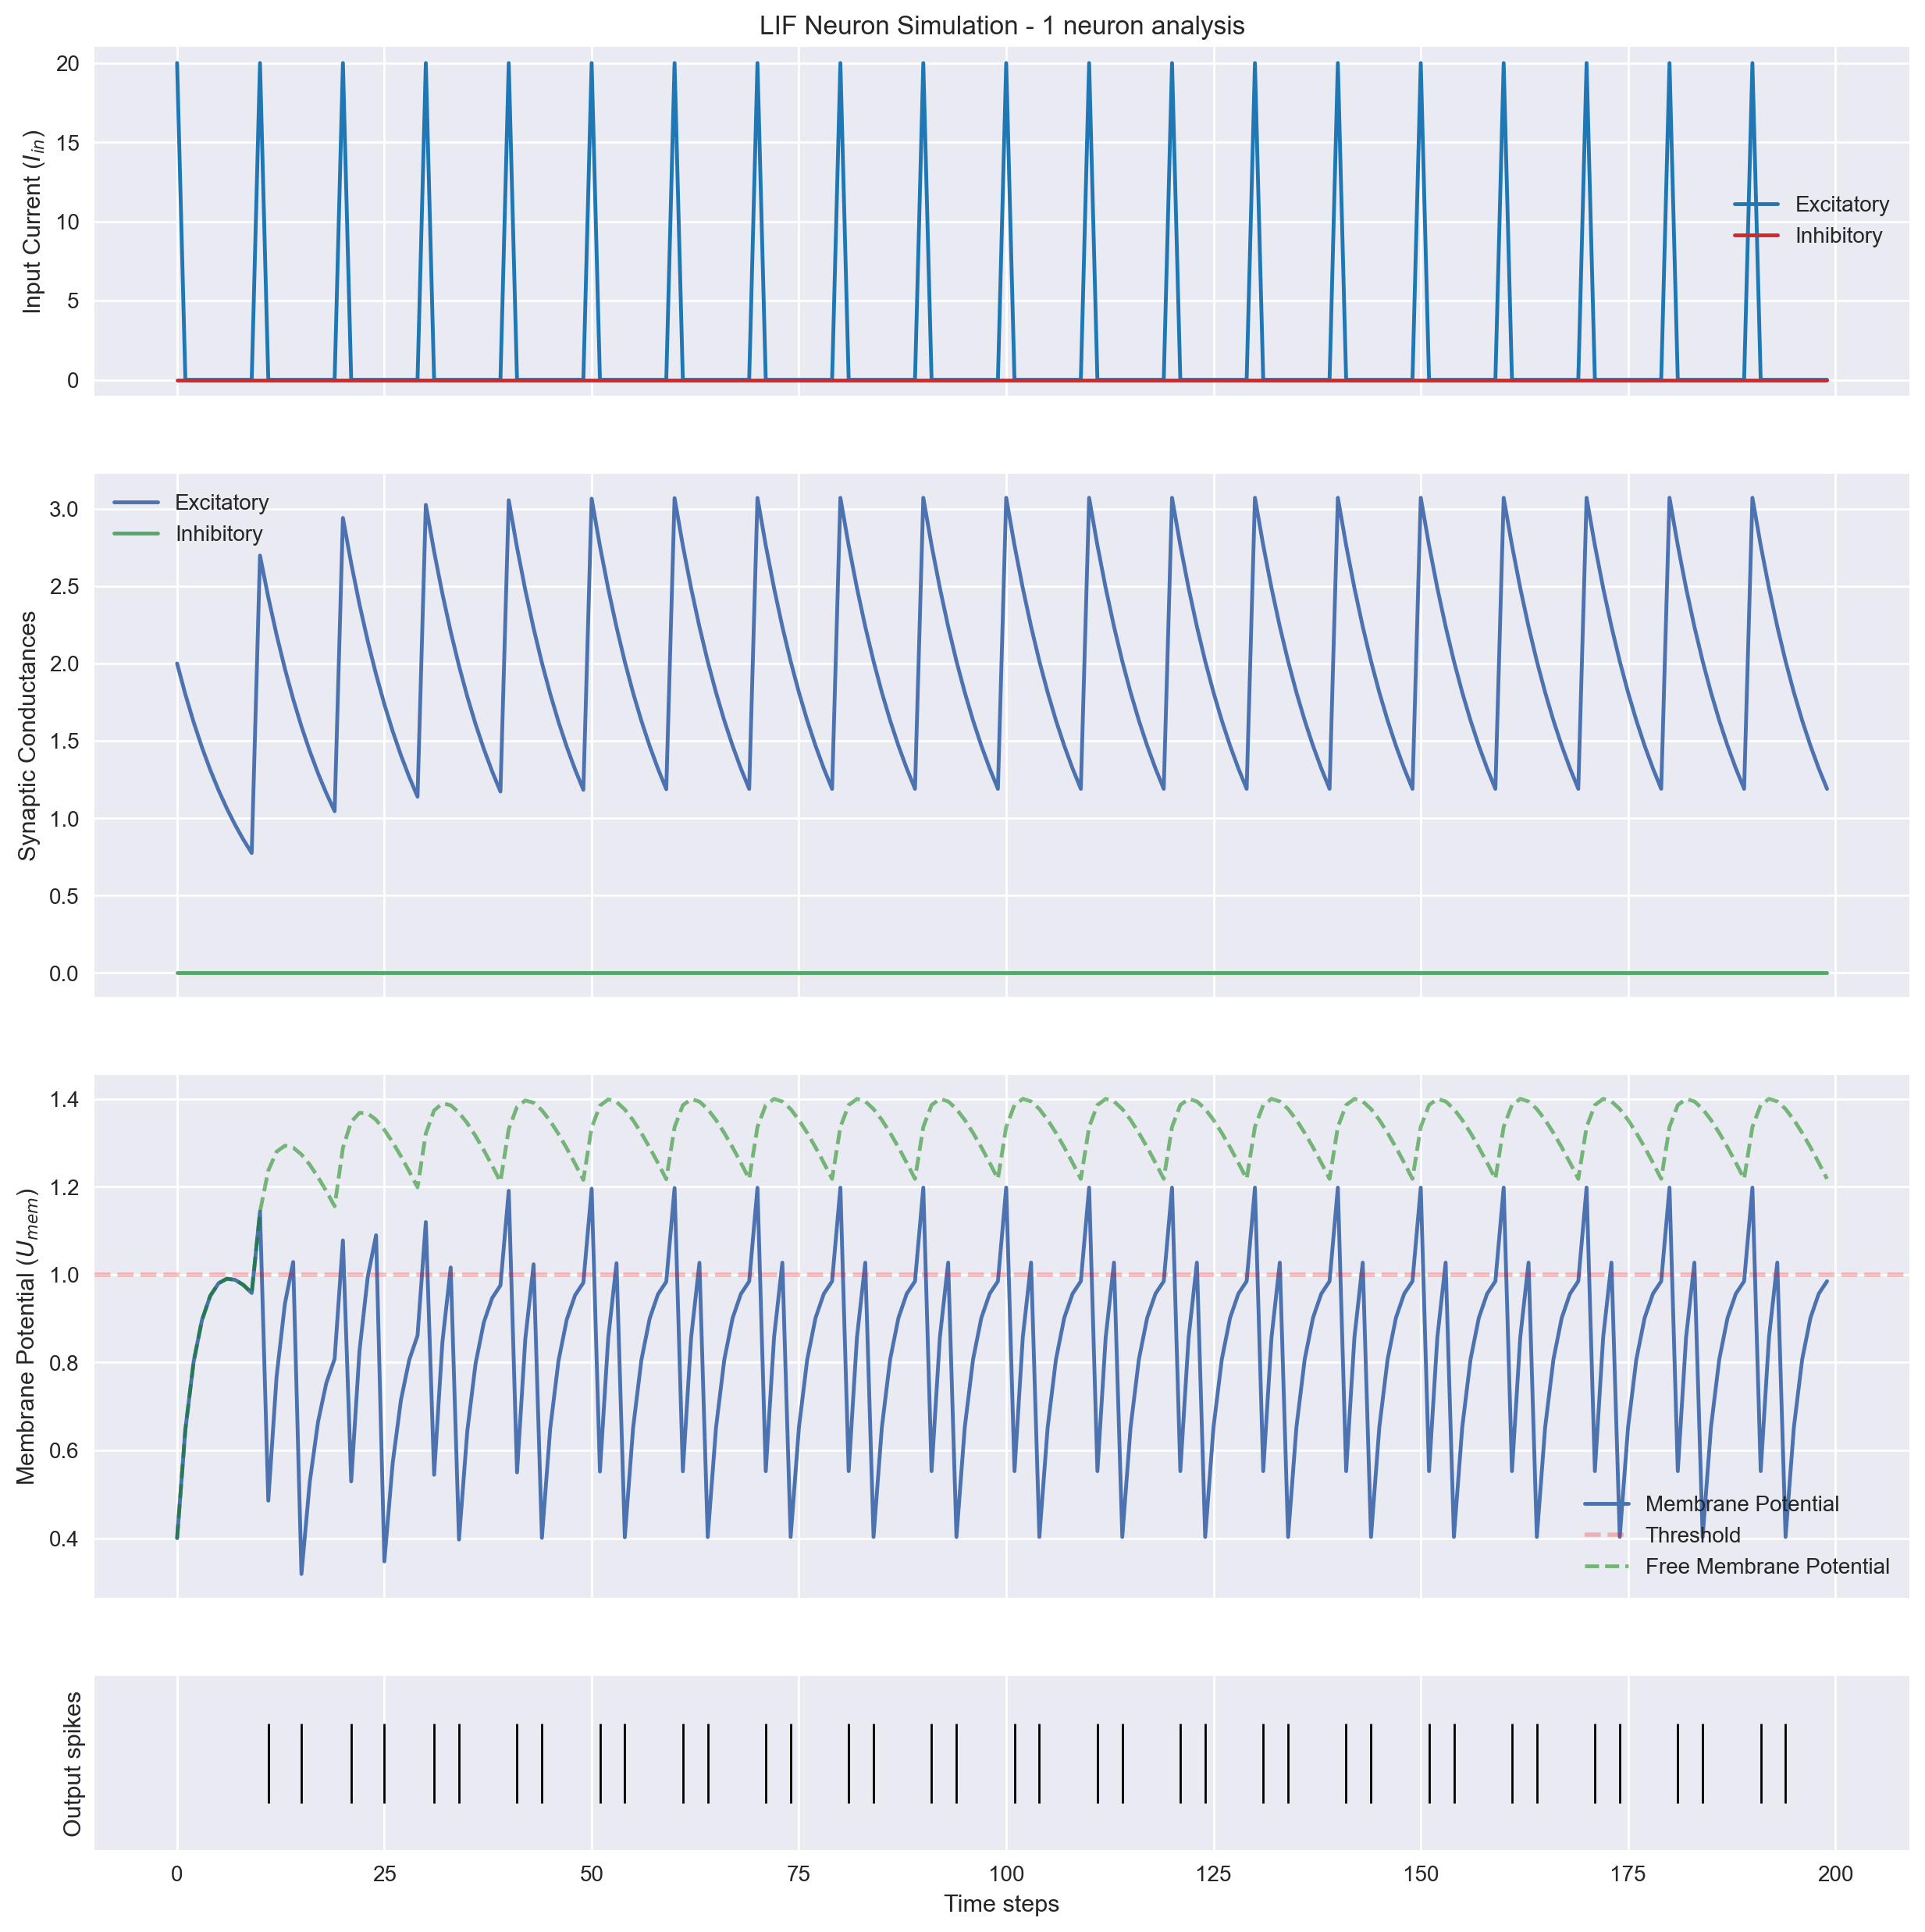

In [4]:
N_pre = 2
N_post = 1
num_steps = 200
pars = default_pars(type_parameters = 'simple', dt = 1, w_init_value = 10, 
                    U_rev_exc = 2,
                    dynamic_threshold = False, 
                    refractory_time = False,
                    t_ref = 1,)
I_exc = Poisson_generator(pars, rate=0.05, N_pre = N_pre, num_steps = num_steps)
I_exc = repeat_ones(num_steps=num_steps, N_pre=N_pre, silent_time=10)

conductance = simulation(pars, I_exc, N_post = N_post, neuron_type = LIF_syn_conductance, W_init = weight_initializer(pars, I = I_exc, N_post = N_post))

get_post_spk_trains = lambda neuron_list : np.array([neuron_list[i].get_records()['spk'] for i in range(len(neuron_list))]).T

raster_plot(pars, pre_syn_spk=I_exc, post_syn_spk=get_post_spk_trains(conductance), title = 'Raster plot of the input and output spikes')

conductance[0].plot_records(title="LIF Neuron Simulation - 1 neuron analysis", show_fmp=True)


## Poisson Neuron Model

First we will need a function to generate Poisson Spike Trains.

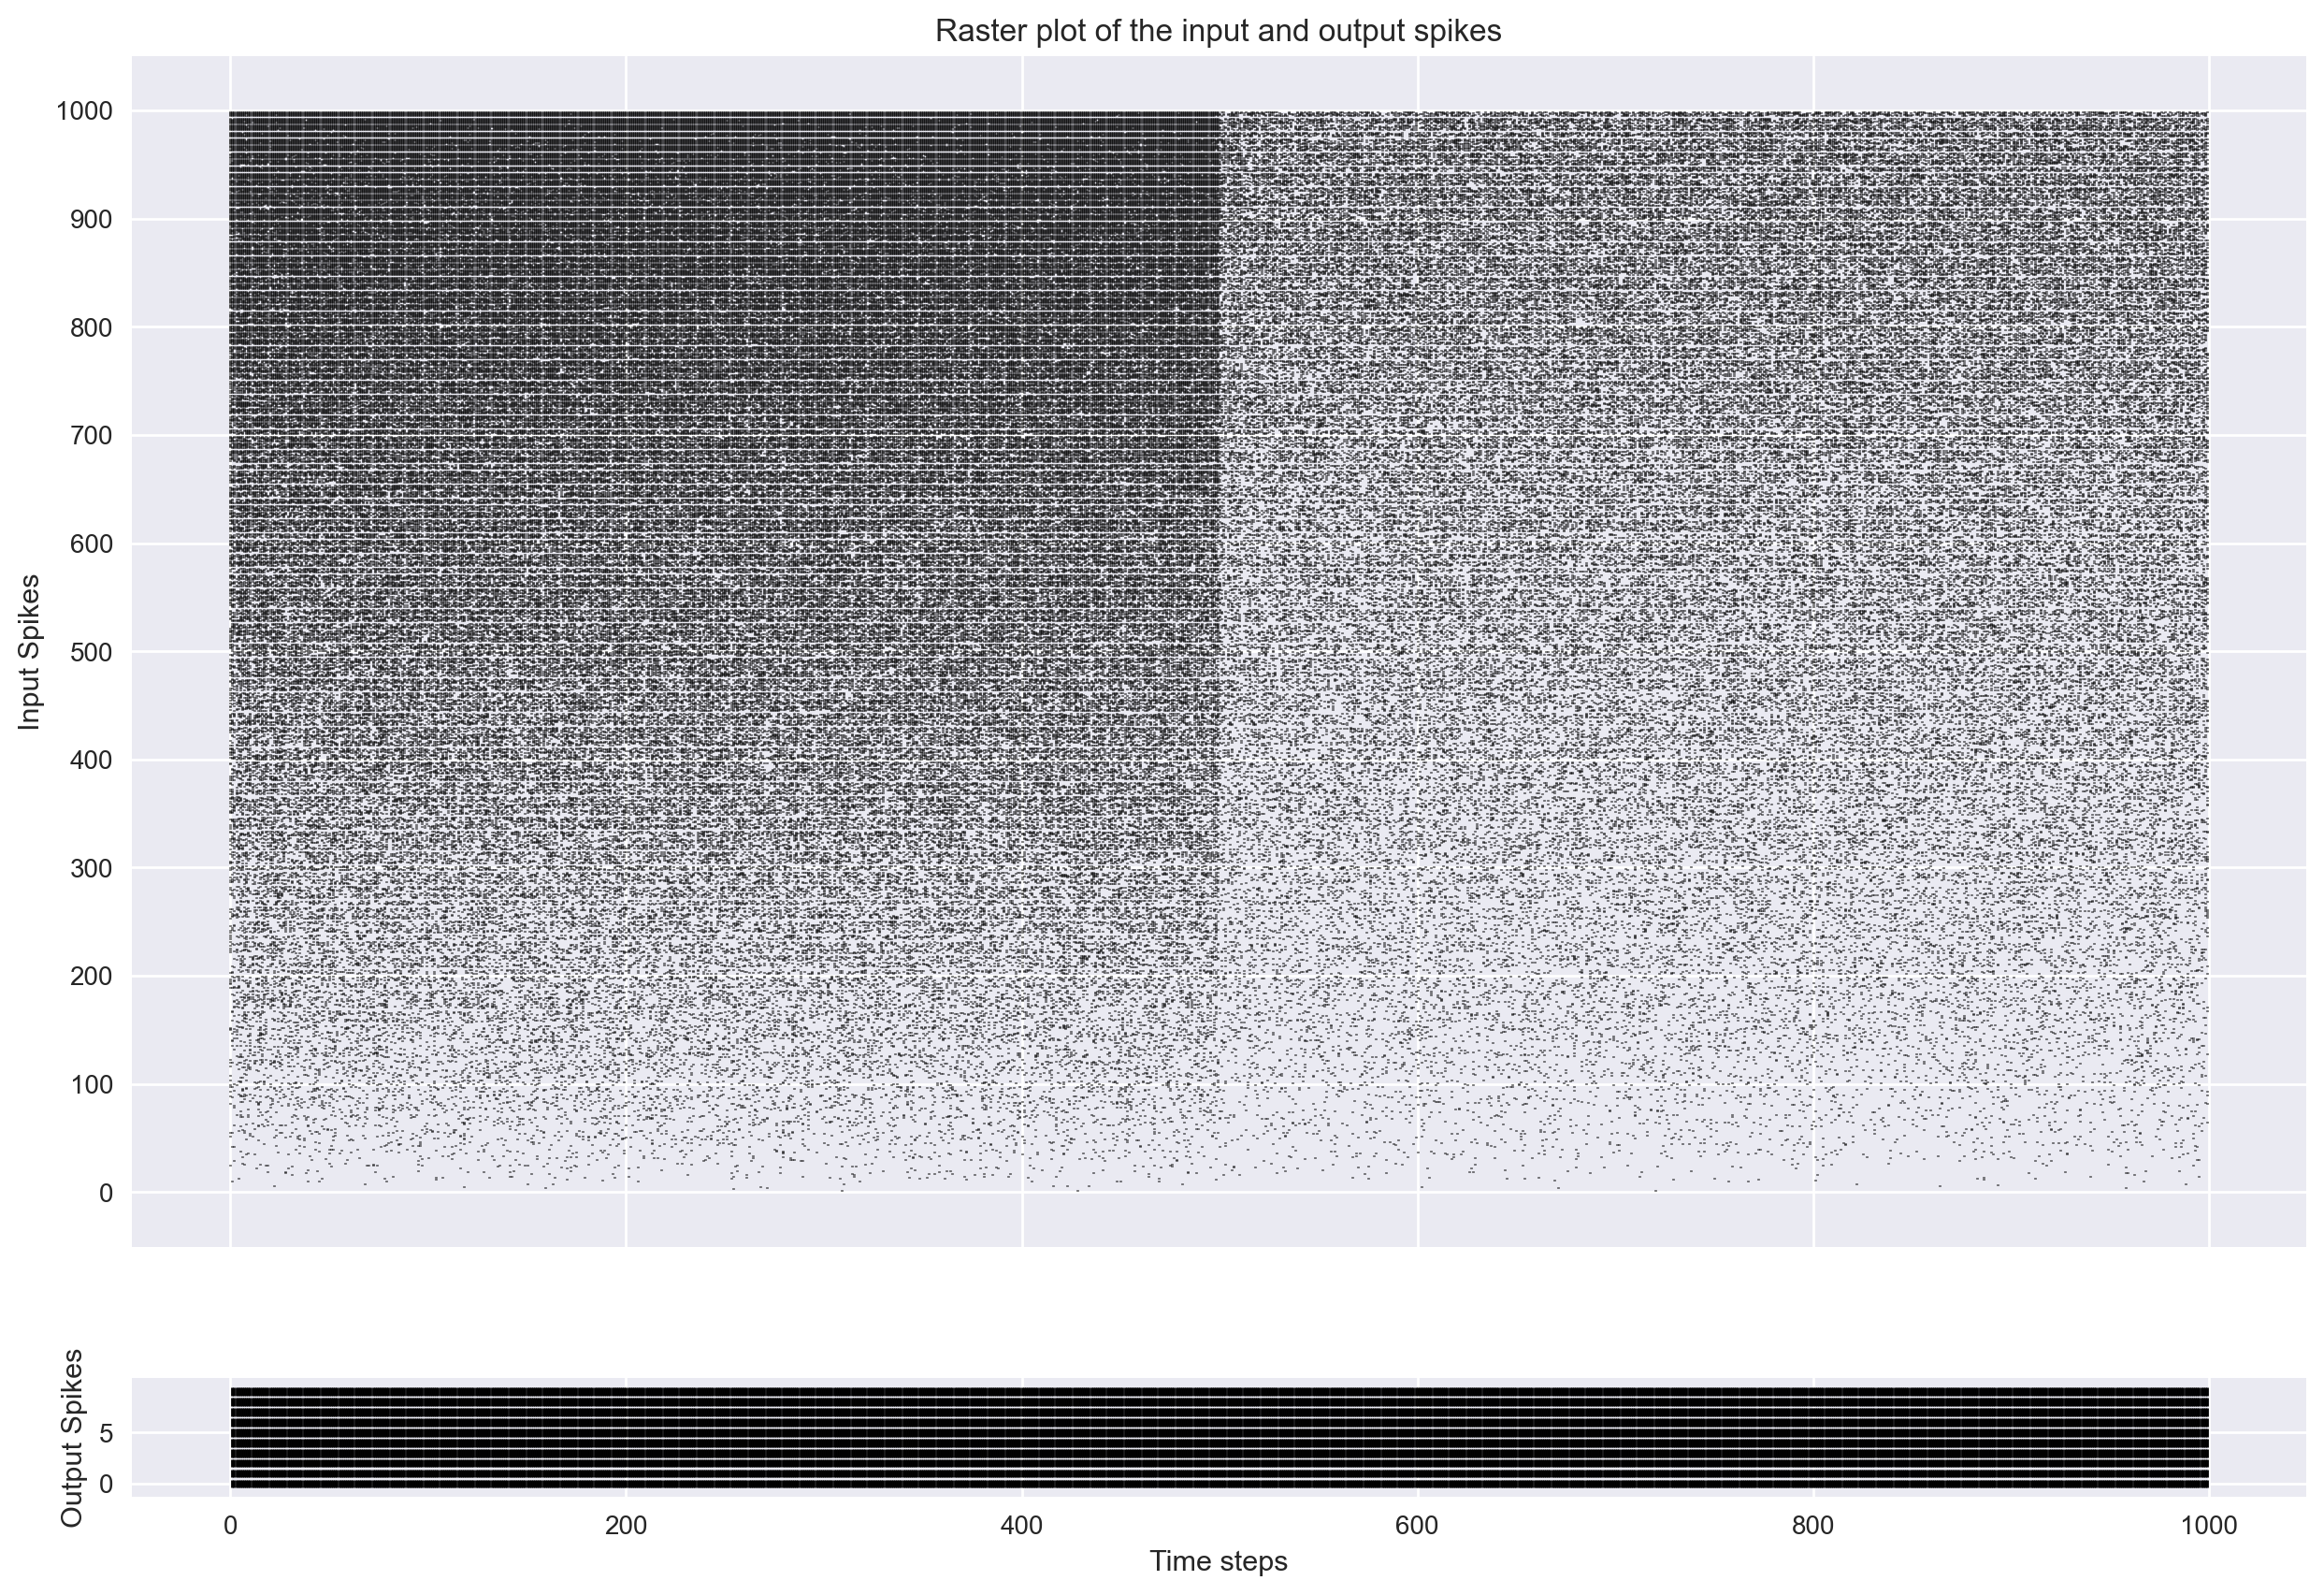

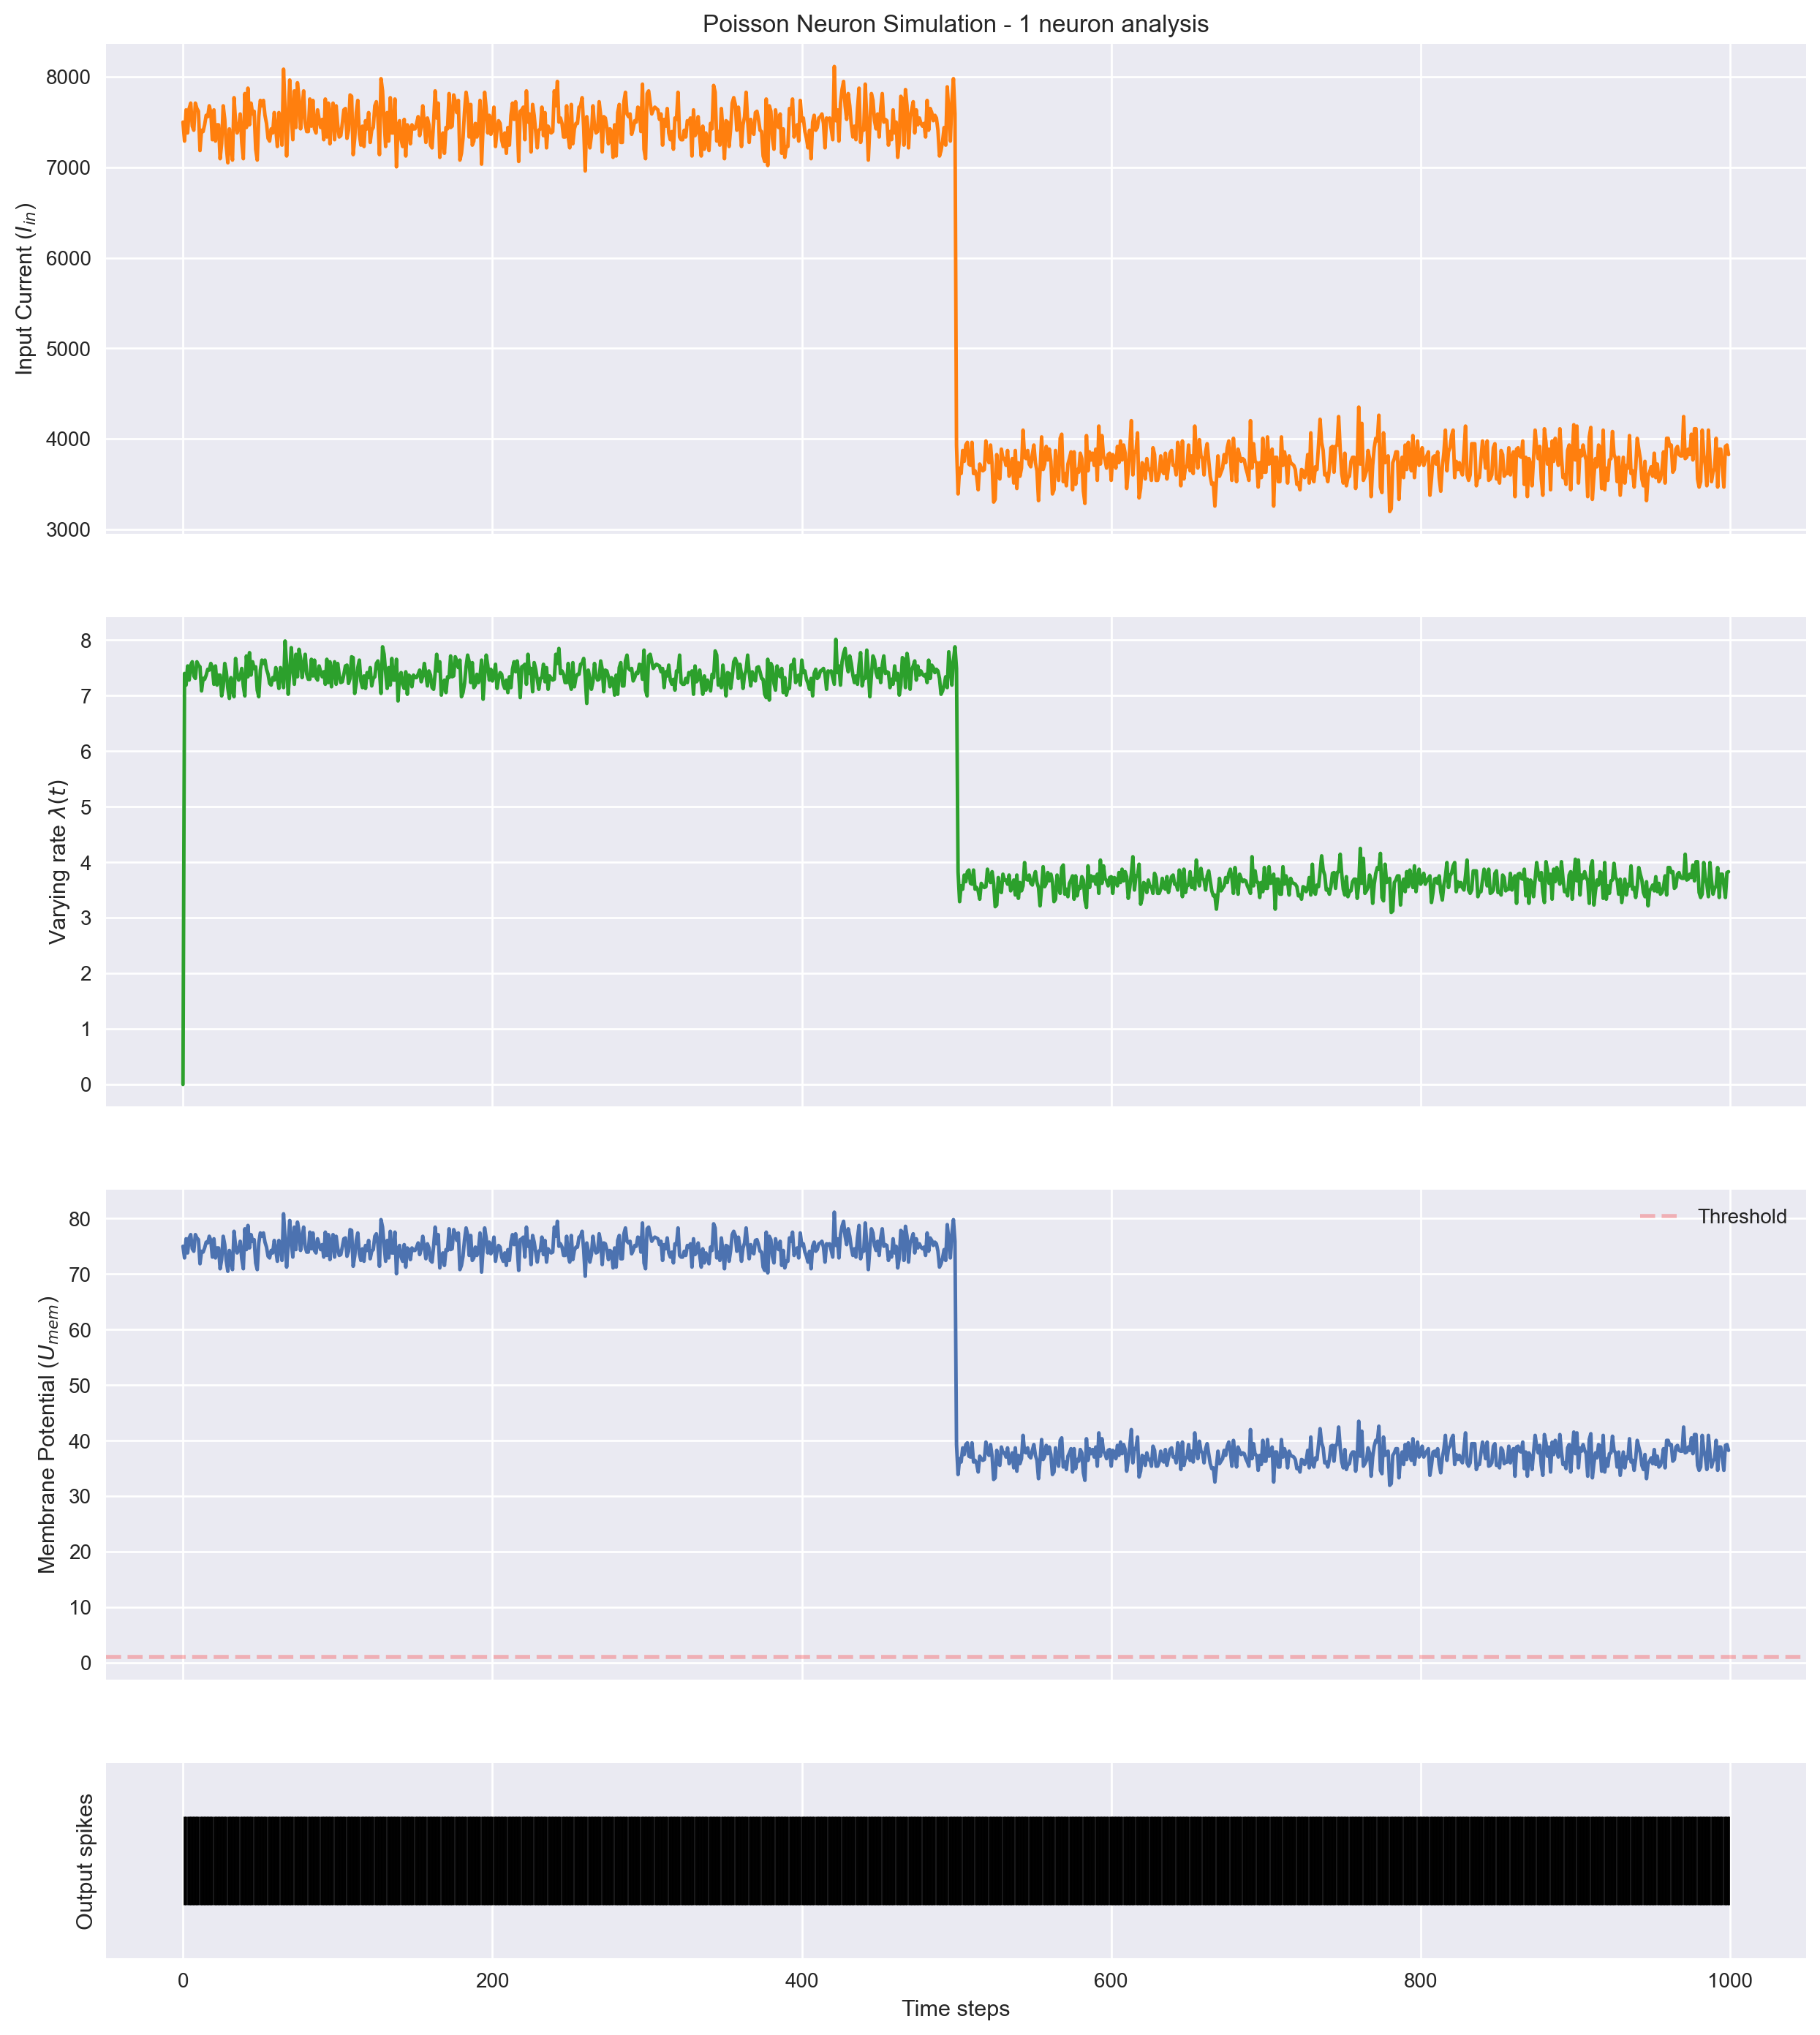

In [5]:
# simple Poisson simulation and plot
N_pre = 1000
num_steps = 1000 
N_post = 10
pars = default_pars(alpha = 0.5, t_ref=2, ratio_thr = 1.5, R=0.1, tau_thr = 40,
                    refractory_time = False, 
                    dynamic_threshold = False, 
                    hard_reset = True)

I = half_growing_rate(pars, num_steps, N_pre, rate_ratio = 0.5)

W_init = weight_initializer(pars, I = I, N_post = N_post)*30

poisson = simulation(pars, I, neuron_type = PoissonNeuron, N_post = N_post, W_init = W_init)

raster_plot(pars, pre_syn_spk=I, post_syn_spk=get_post_spk_trains(poisson), title = 'Raster plot of the input and output spikes')

poisson[0].plot_records(title="Poisson Neuron Simulation - 1 neuron analysis")

# Spike time based algorithms

We now can implement the STDP update rule, which relies on the pre and post synaptic traces of the neurons.

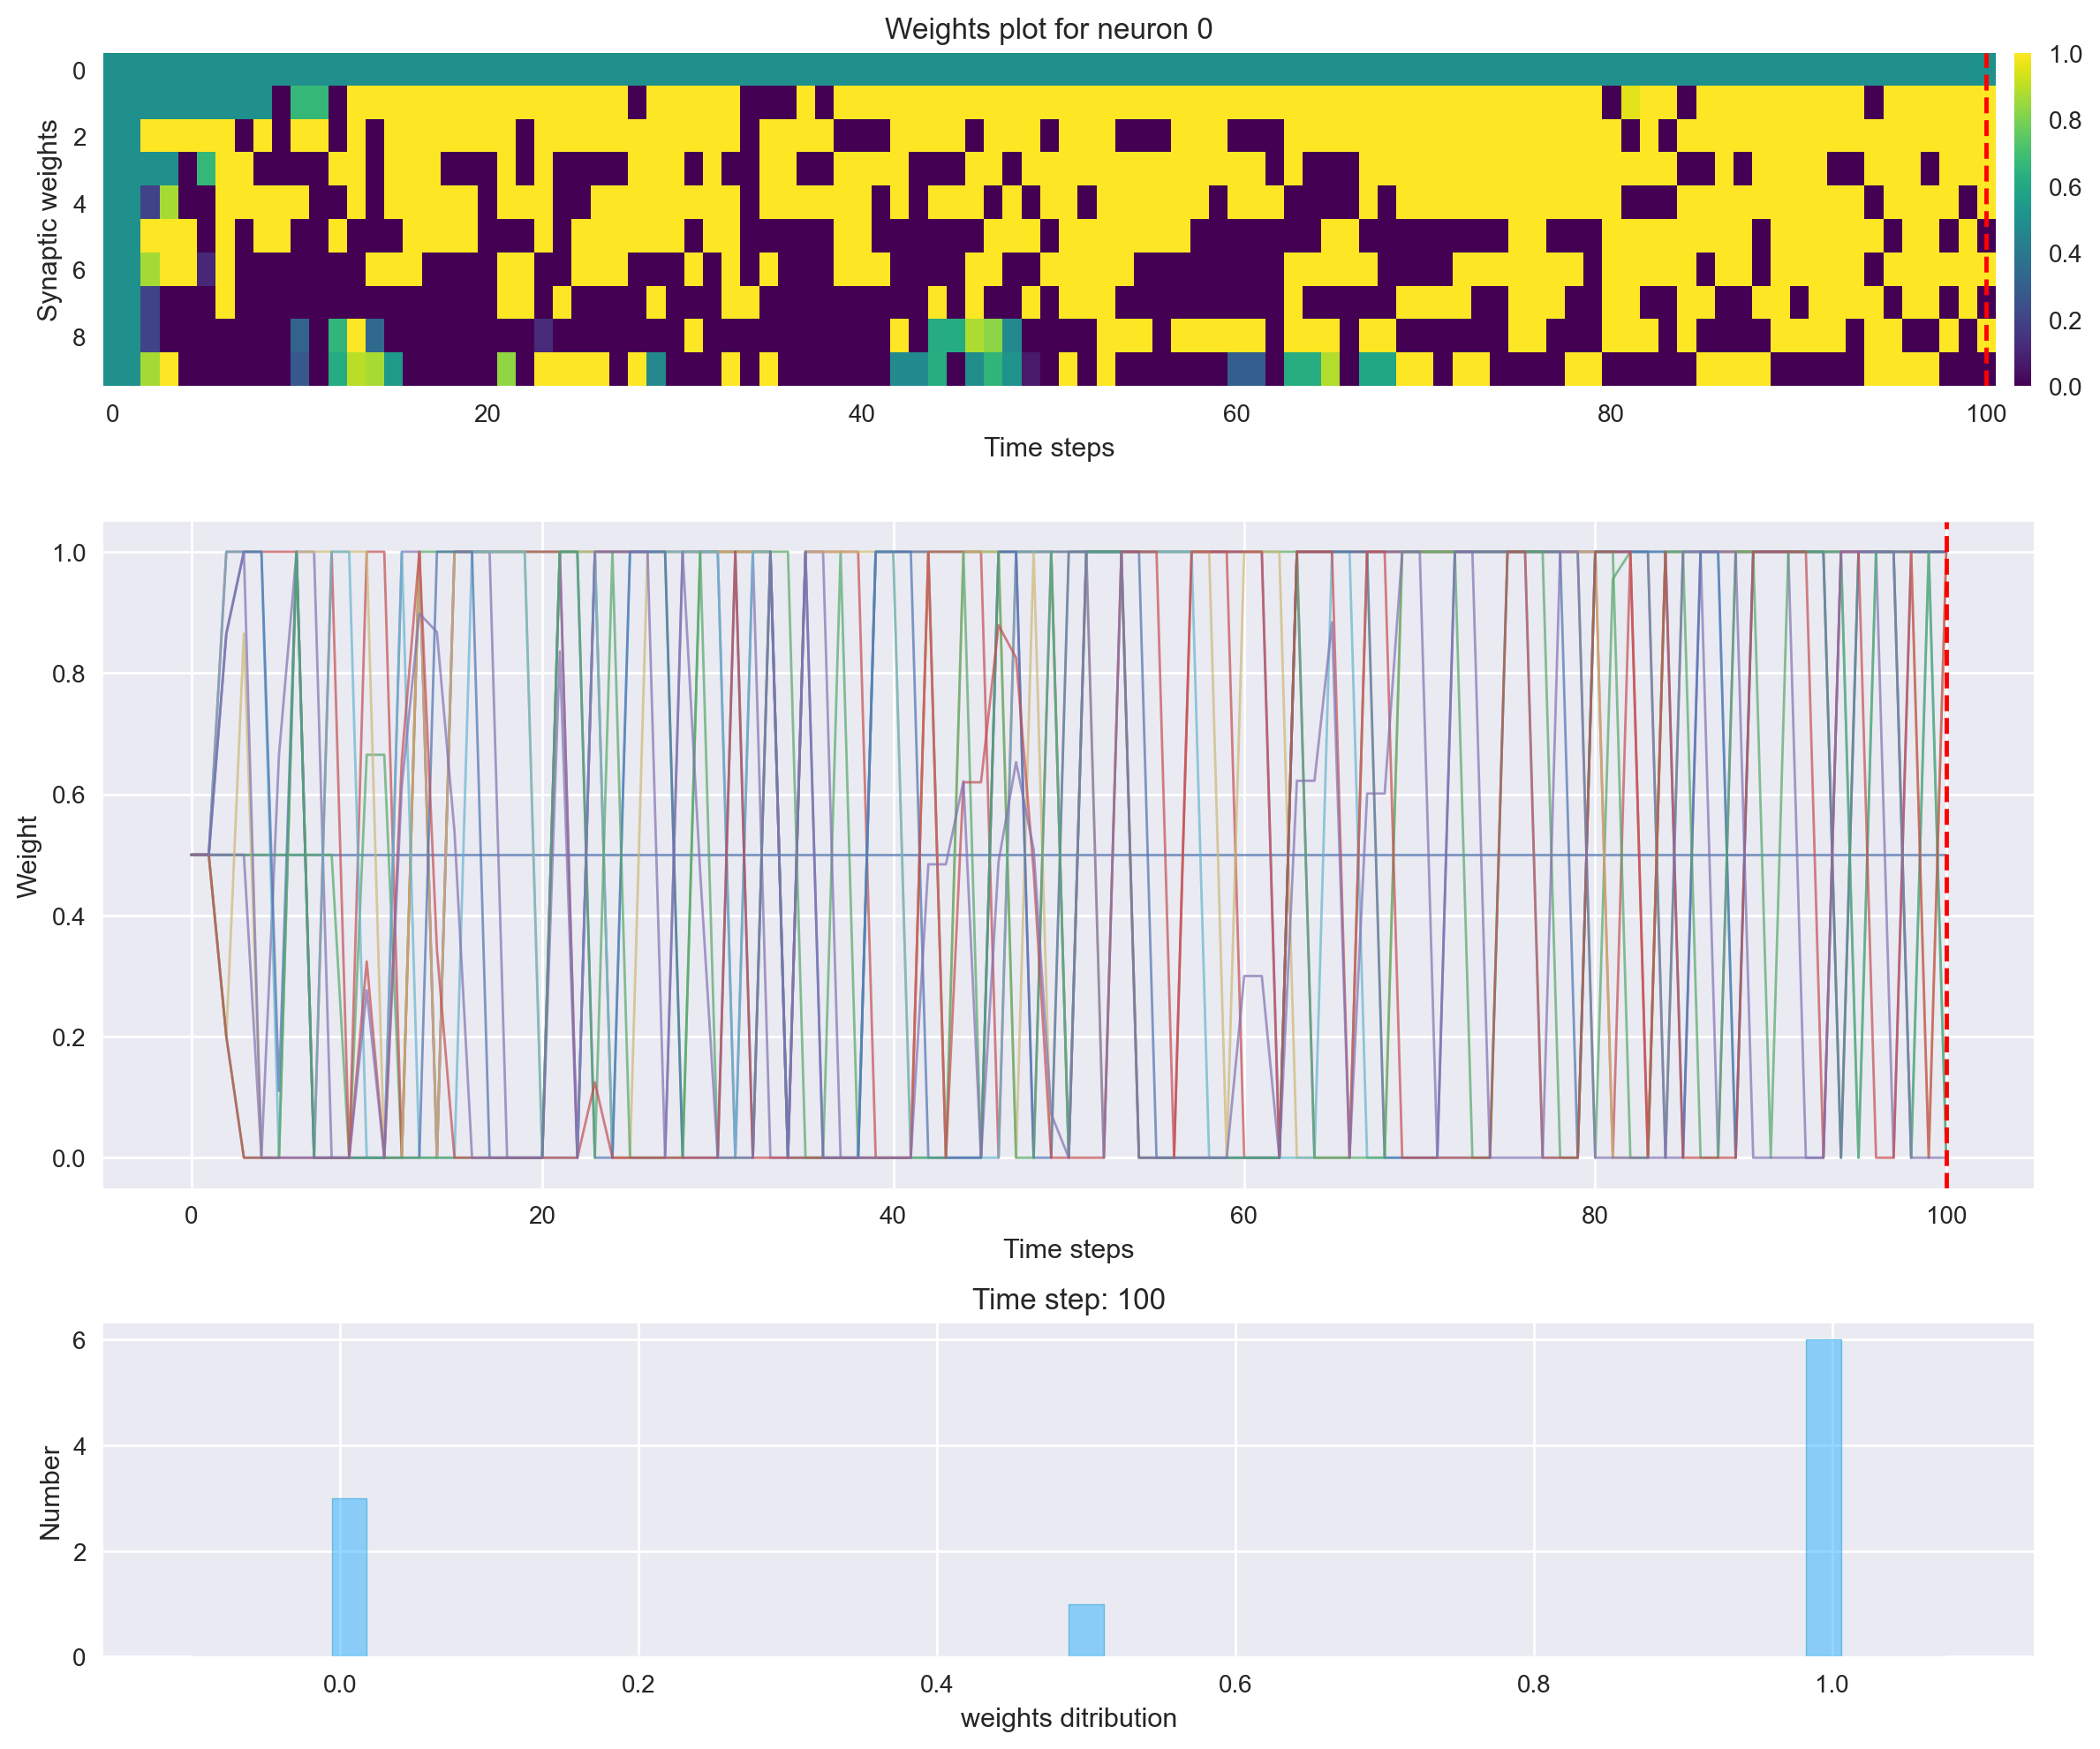

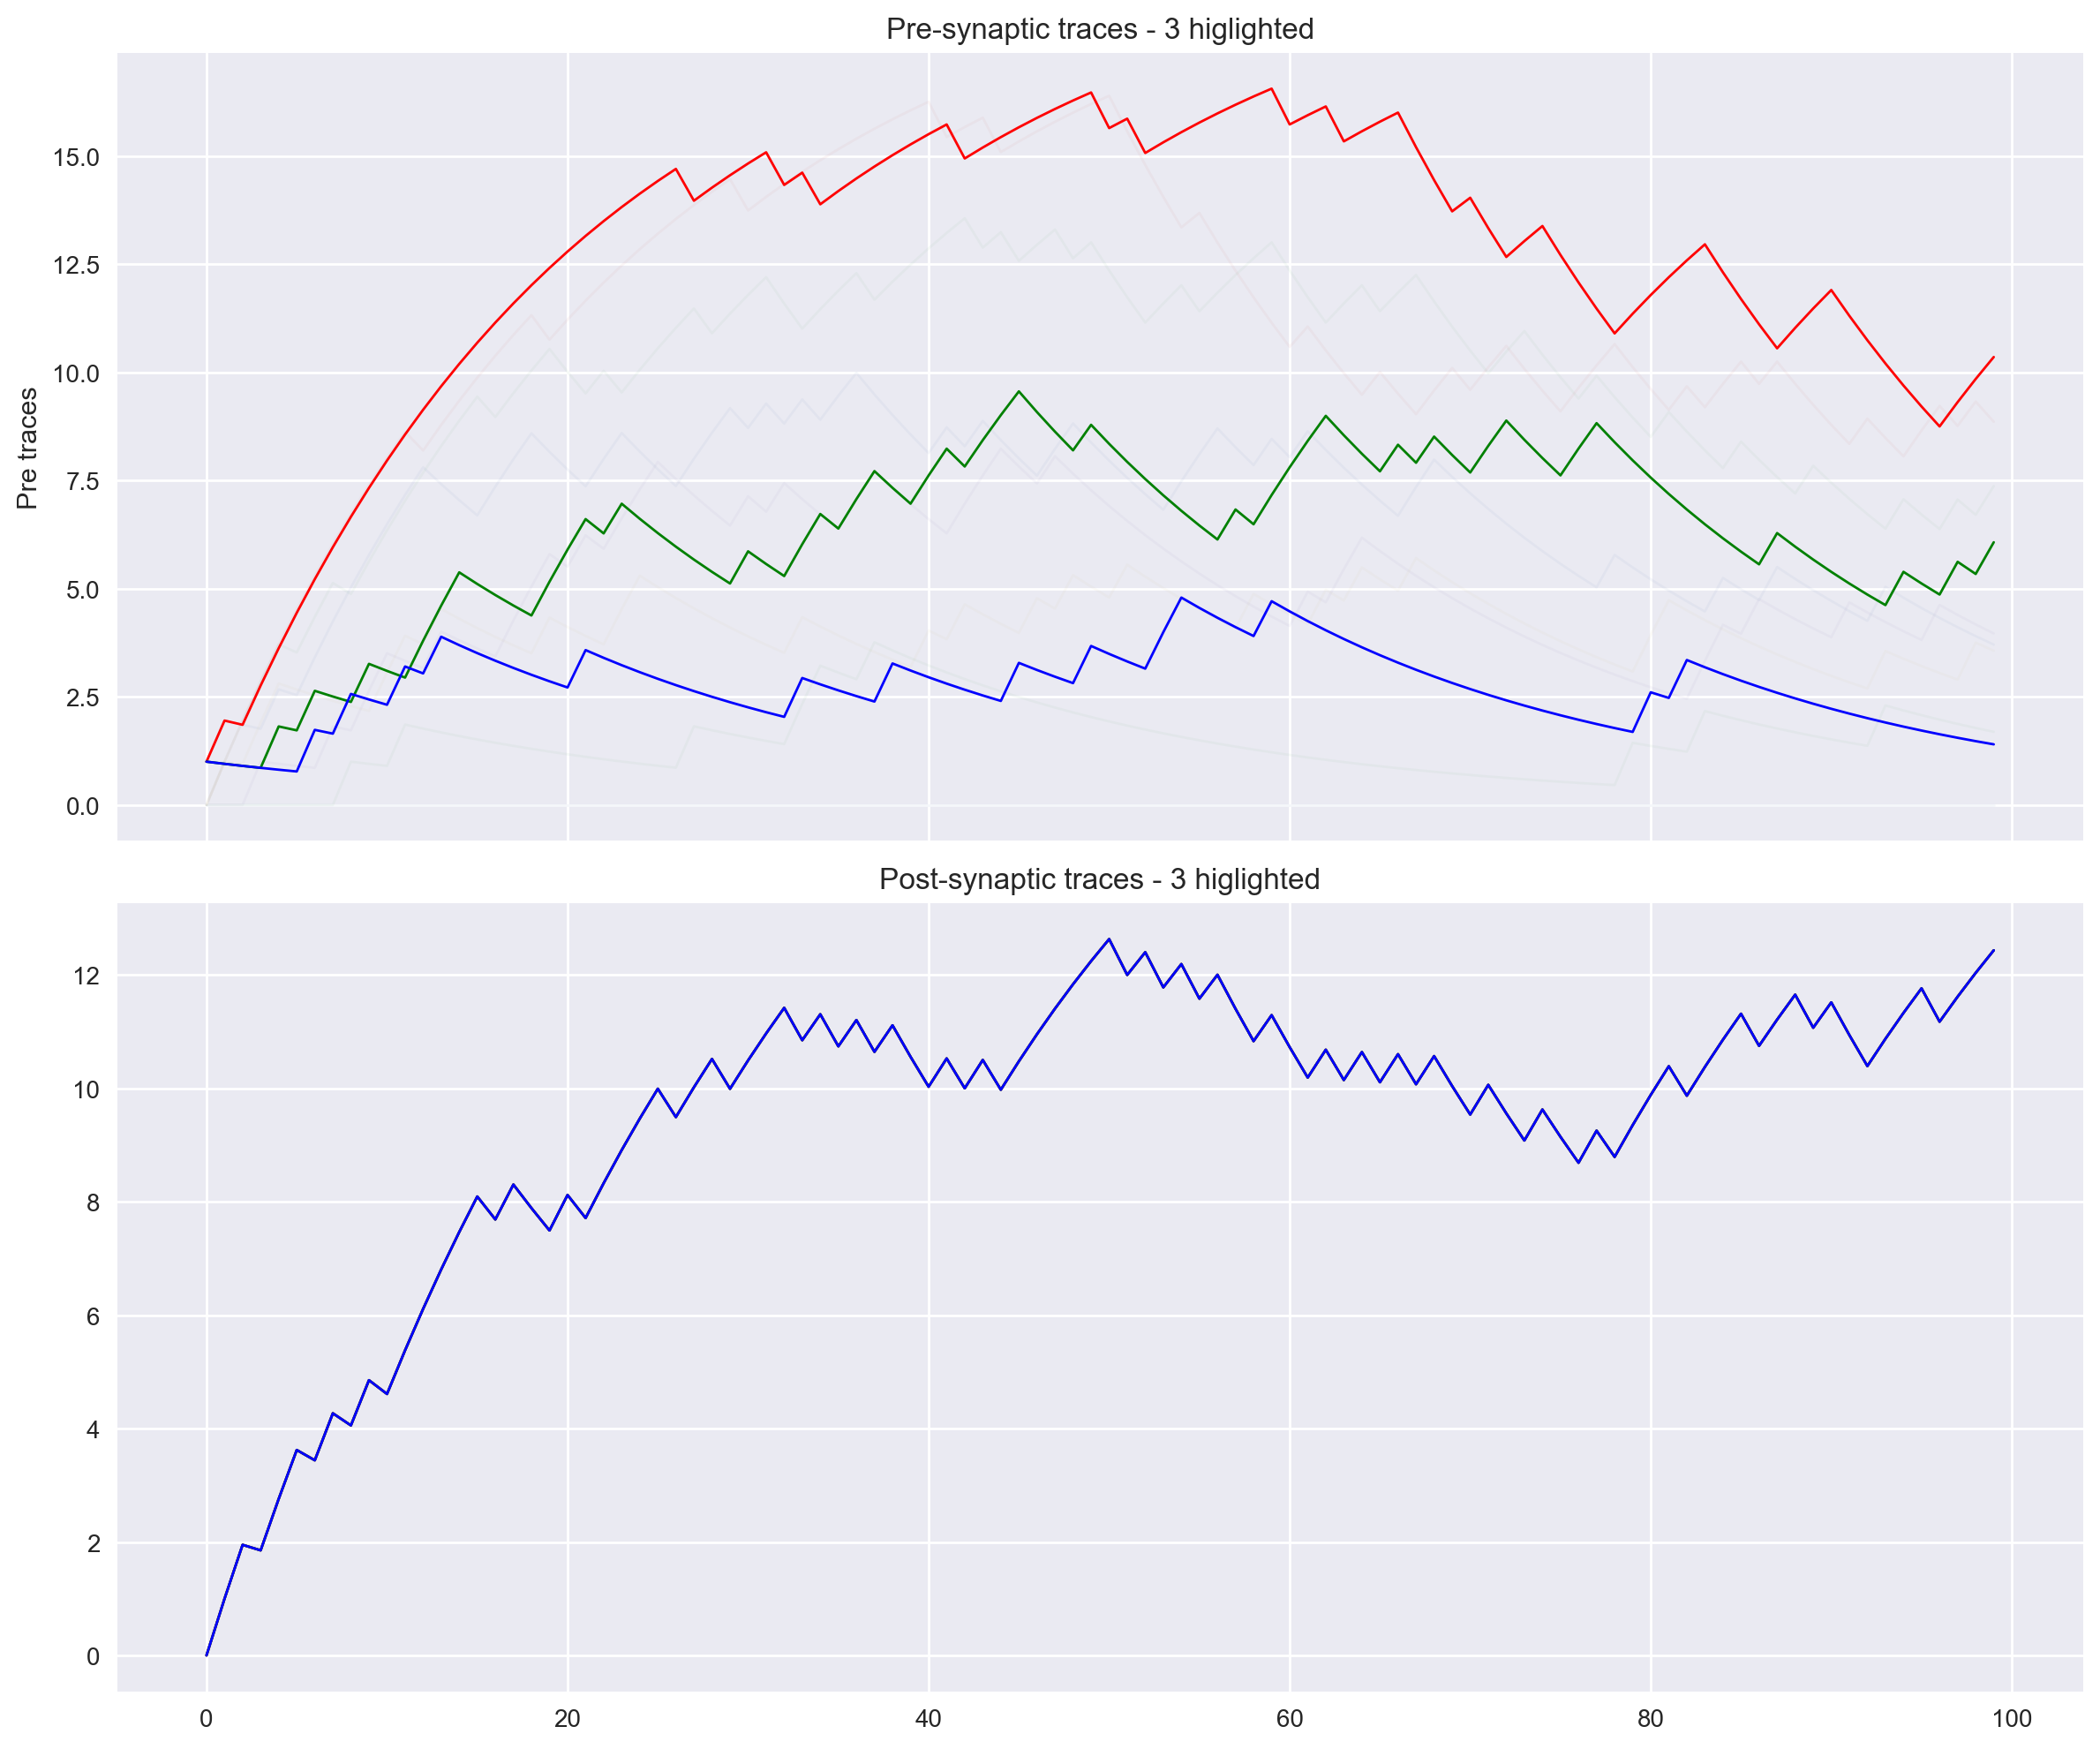

In [6]:
# simple Poisson simulation and plot
N_pre = 10
num_steps = 100  # that is 100 milliseconds
N_post = 10

pars = default_pars( A_plus = 0.7, A_minus = 1, tau_plus = 20, tau_minus = 20, w_max = 1, w_min = 0., R = 10, dynamic_weight_exponent = 0.2,
                    refractory_time = False,
                    dynamic_threshold = False,
                    hard_reset = True,
                    short_memory_trace = False,
                    constrain = 'Hard'
                    )
                    

# input spike train
I = half_growing_rate(pars, num_steps, N_pre, rate_ratio = 0.5)

W_init = weight_initializer(pars, N_post, I=I)

neuron, syn = simulation(pars, I, neuron_type = LIFNeuron, W_init=W_init, weight_rule = STDP_synapse, N_post = N_post)

#raster_plot(pars, I, np.array([neurons[i].get_records()['spk'] for i in range(N_post)]).T, title = 'Raster plot of the input and output spikes')


neuron_index = 0
#neuron[neuron_index].plot_records(title="First LIF Neuron Simulation with STDP plots")

weights_plot(pars, syn.get_records()['W'][:,neuron_index,:], time_step = num_steps, title = f'Weights plot for neuron {neuron_index}')

weights_history = syn.get_records()['W']
pre_trace_record = syn.get_records()['pre_trace']
post_trace_record = syn.get_records()['post_trace']
time_steps = np.arange(0, len(weights_history), 1)

plot_traces(pars, pre_trace_record, post_trace_record, pre_trace_index_list=[9,5,2])

In [7]:
N_pre = 30
num_steps = 100  # that is 100 milliseconds
N_post = 10
dt = default_pars()['dt']

I = half_growing_rate(dt, num_steps, N_pre, rate_ratio = 0.5)

interactive_plot_2 = STDP_interactive_plot(pars_function = default_pars, I=I, N_post = N_post,
                          manual_update = False, 
                          )

display(interactive_plot_2)

# Turn the screw on STDP

## STDP with synaptic conductance neurons

array([[0.58801452, 0.69910875, 0.18815196, 0.04380856, 0.20501895,
        0.10606287, 0.72724014, 0.67940052, 0.4738457 , 0.44829582,
        0.01910695, 0.75259834, 0.60244854, 0.96177758, 0.66436865,
        0.60662962, 0.44915131, 0.22535416, 0.6701743 , 0.73576659,
        0.25799564, 0.09554215, 0.96090974, 0.25176729, 0.28216512,
        0.76825393, 0.7979234 , 0.5440372 , 0.38270763, 0.38165095,
        0.28582739, 0.74026815, 0.23898683, 0.4377217 , 0.8835387 ,
        0.28928114, 0.78450686, 0.75895366, 0.41778538, 0.22576877,
        0.42009814, 0.06436369, 0.59643269, 0.83732372, 0.89248639,
        0.20052744, 0.50239523, 0.89538184, 0.25592093, 0.86723234,
        0.01648793, 0.55249695, 0.52790539, 0.92335039, 0.24594844,
        0.06401838, 0.9021047 , 0.8740398 , 0.16366729, 0.99974131,
        0.34680397, 0.31287816, 0.84710402, 0.8802311 , 0.67655865,
        0.05367515, 0.55921377, 0.69451294, 0.8241973 , 0.31142866,
        0.50523054, 0.84900379, 0.29351563, 0.67

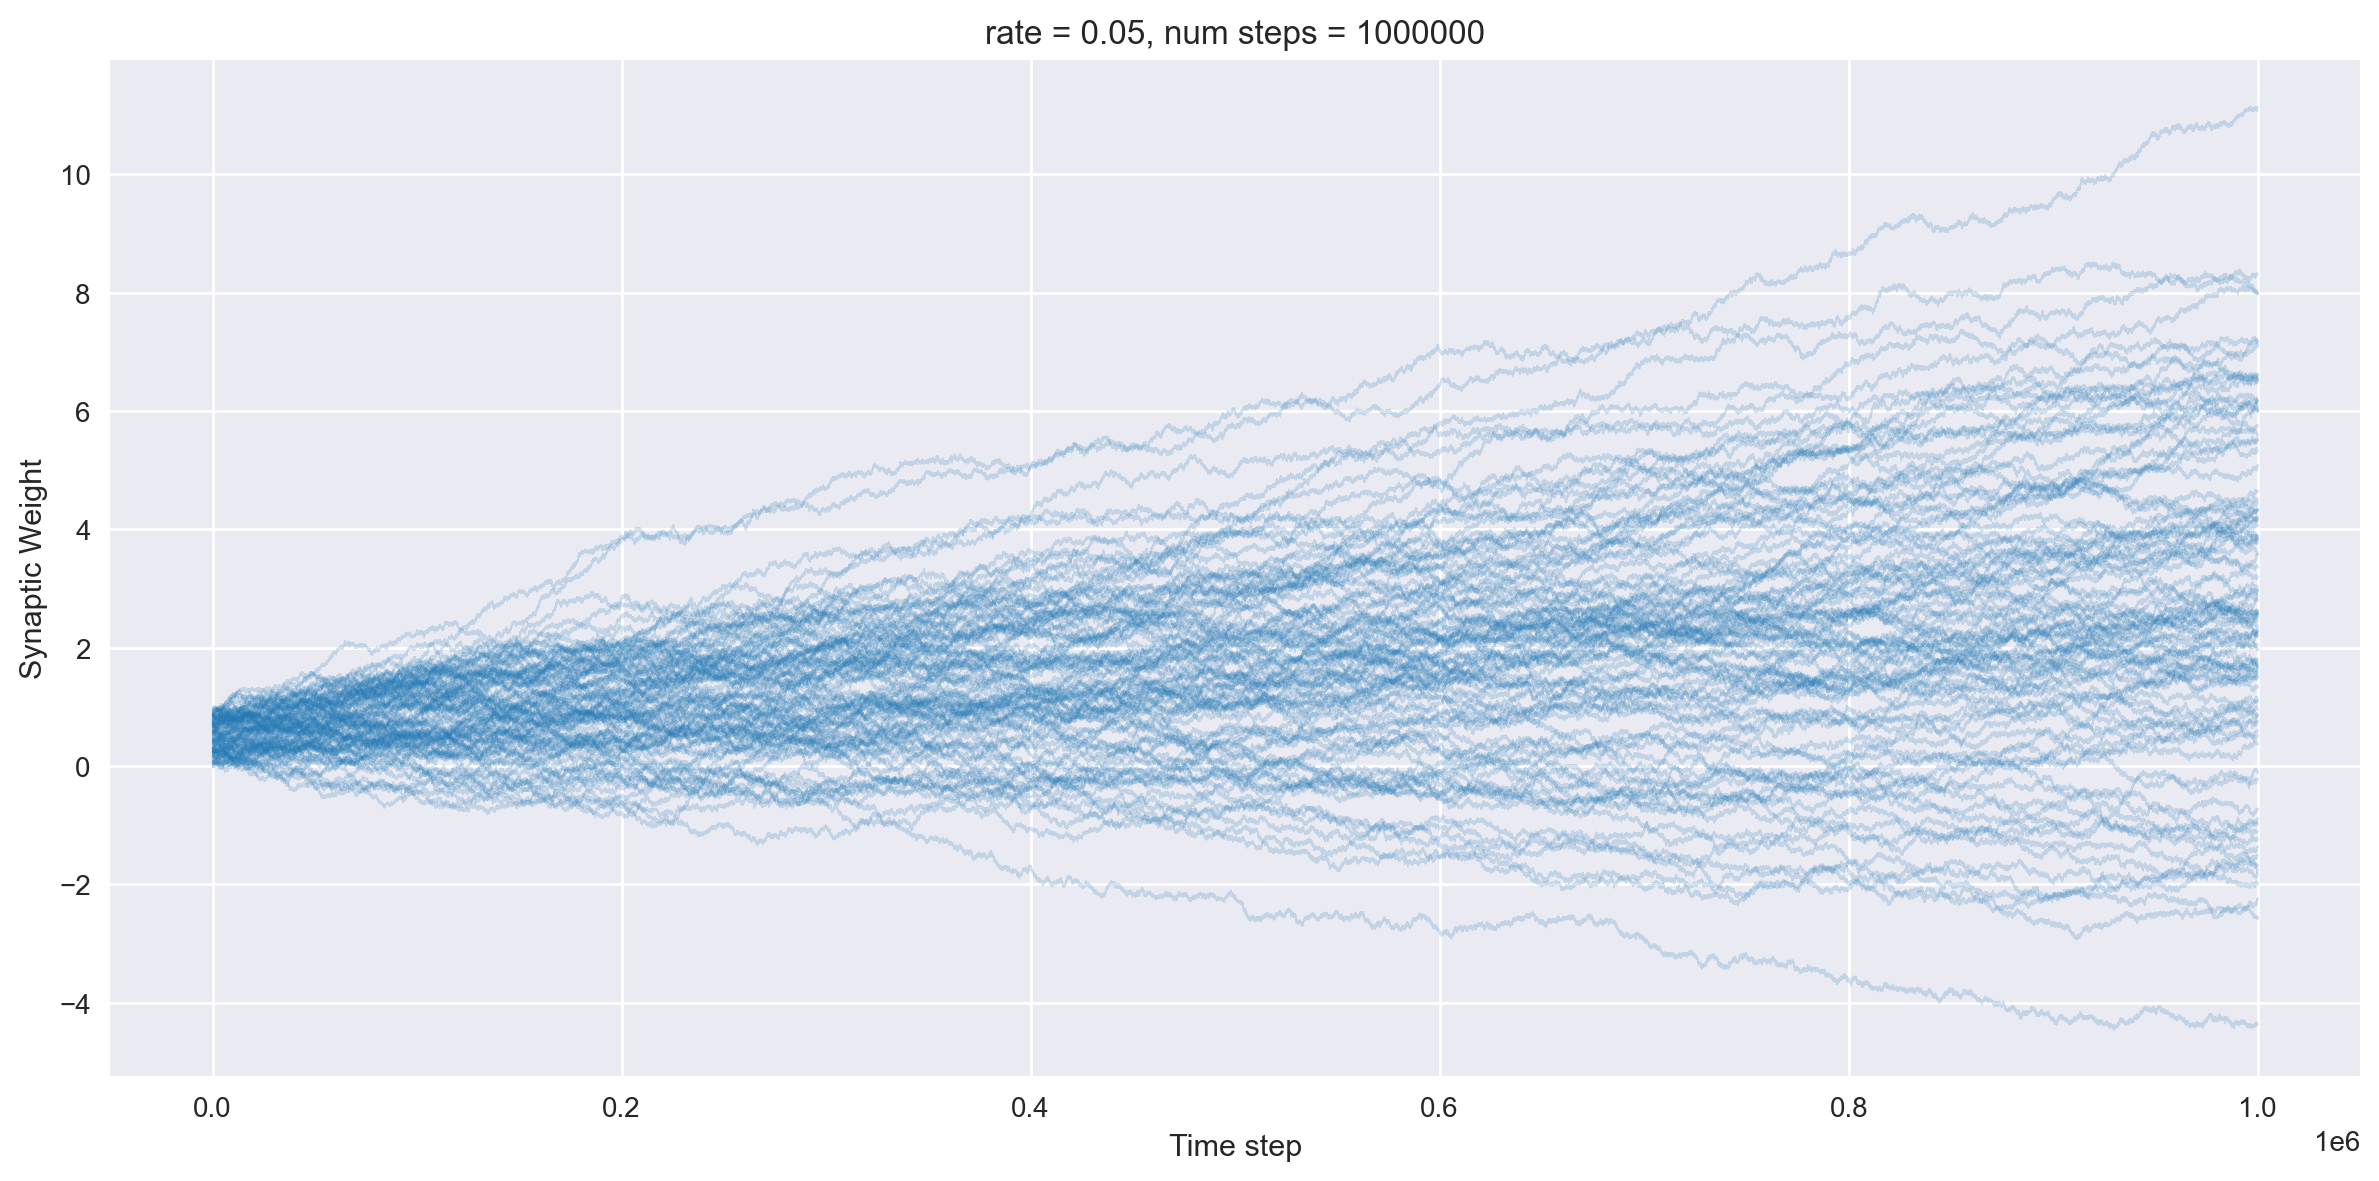

In [6]:
# I use this cell to conduct the final experiments for the thesis, it is no more coherent with the previous cells

dt=1

# simple Poisson simulation and plot
N_pre = 100
num_steps = 1000000 # 200000 steps in 14 sec with no raster plot
N_post = 1

pars = default_pars( A_plus = 0.01, A_minus = 0.01, 
                    tau_plus = 20, tau_minus = 20, 
                    tau_m = 10,
                    w_max = 1., w_min = 0.0, 
                    R = 1, dynamic_weight_exponent = 0.2,
                    refractory_time = True,
                    t_ref = 10.,
                    dynamic_threshold = True,
                    tau_thr = 20 ,     
                    ratio_thr = 1.,  # i changed it additively for the lif neuron
                    hard_reset = False,
                    short_memory_trace = False,
                    constrain = 'None', # constraint in the weight update
                    U_rev_exc = 2, # for the conductance-based LIF neuron
                    )
                    
# poisson generator
# rate values = 0.001, 0.01, 0.05, 0.1, 0.5
rate = 0.05
I_exc = Poisson_generator(dt, rate, N_pre, num_steps)

W_init = weight_initializer(pars, I = I_exc, N_post = N_post, type_init = 1)
display(W_init)
#pars['w_min'] = -40.
neuron, syn = simulation(pars, I_exc, neuron_type = LIFNeuron, W_init=W_init, weight_rule = STDP_synapse, N_post = N_post)

#raster_plot(pars, pre_syn_spk=I_exc, post_syn_spk=get_post_spk_trains(neuron), title = 'Raster plot of the input and output spikes')

neuron_index = 0
#neuron[neuron_index].plot_records(title="STDP with conductance-based LIF neuron")

weights_plot(pars, syn.get_records()['W'][:,neuron_index,:], time_step = num_steps, title = f'rate = {rate}, num steps = {num_steps}')

# weights_history = syn.get_records()['W']
# pre_trace_record = syn.get_records()['pre_trace']
# post_trace_record = syn.get_records()['post_trace']
# time_steps = np.arange(0, len(weights_history), 1)

# plot_traces(pars, pre_trace_record, post_trace_record, pre_trace_index_list=[9,5,2])

## Time shifted input

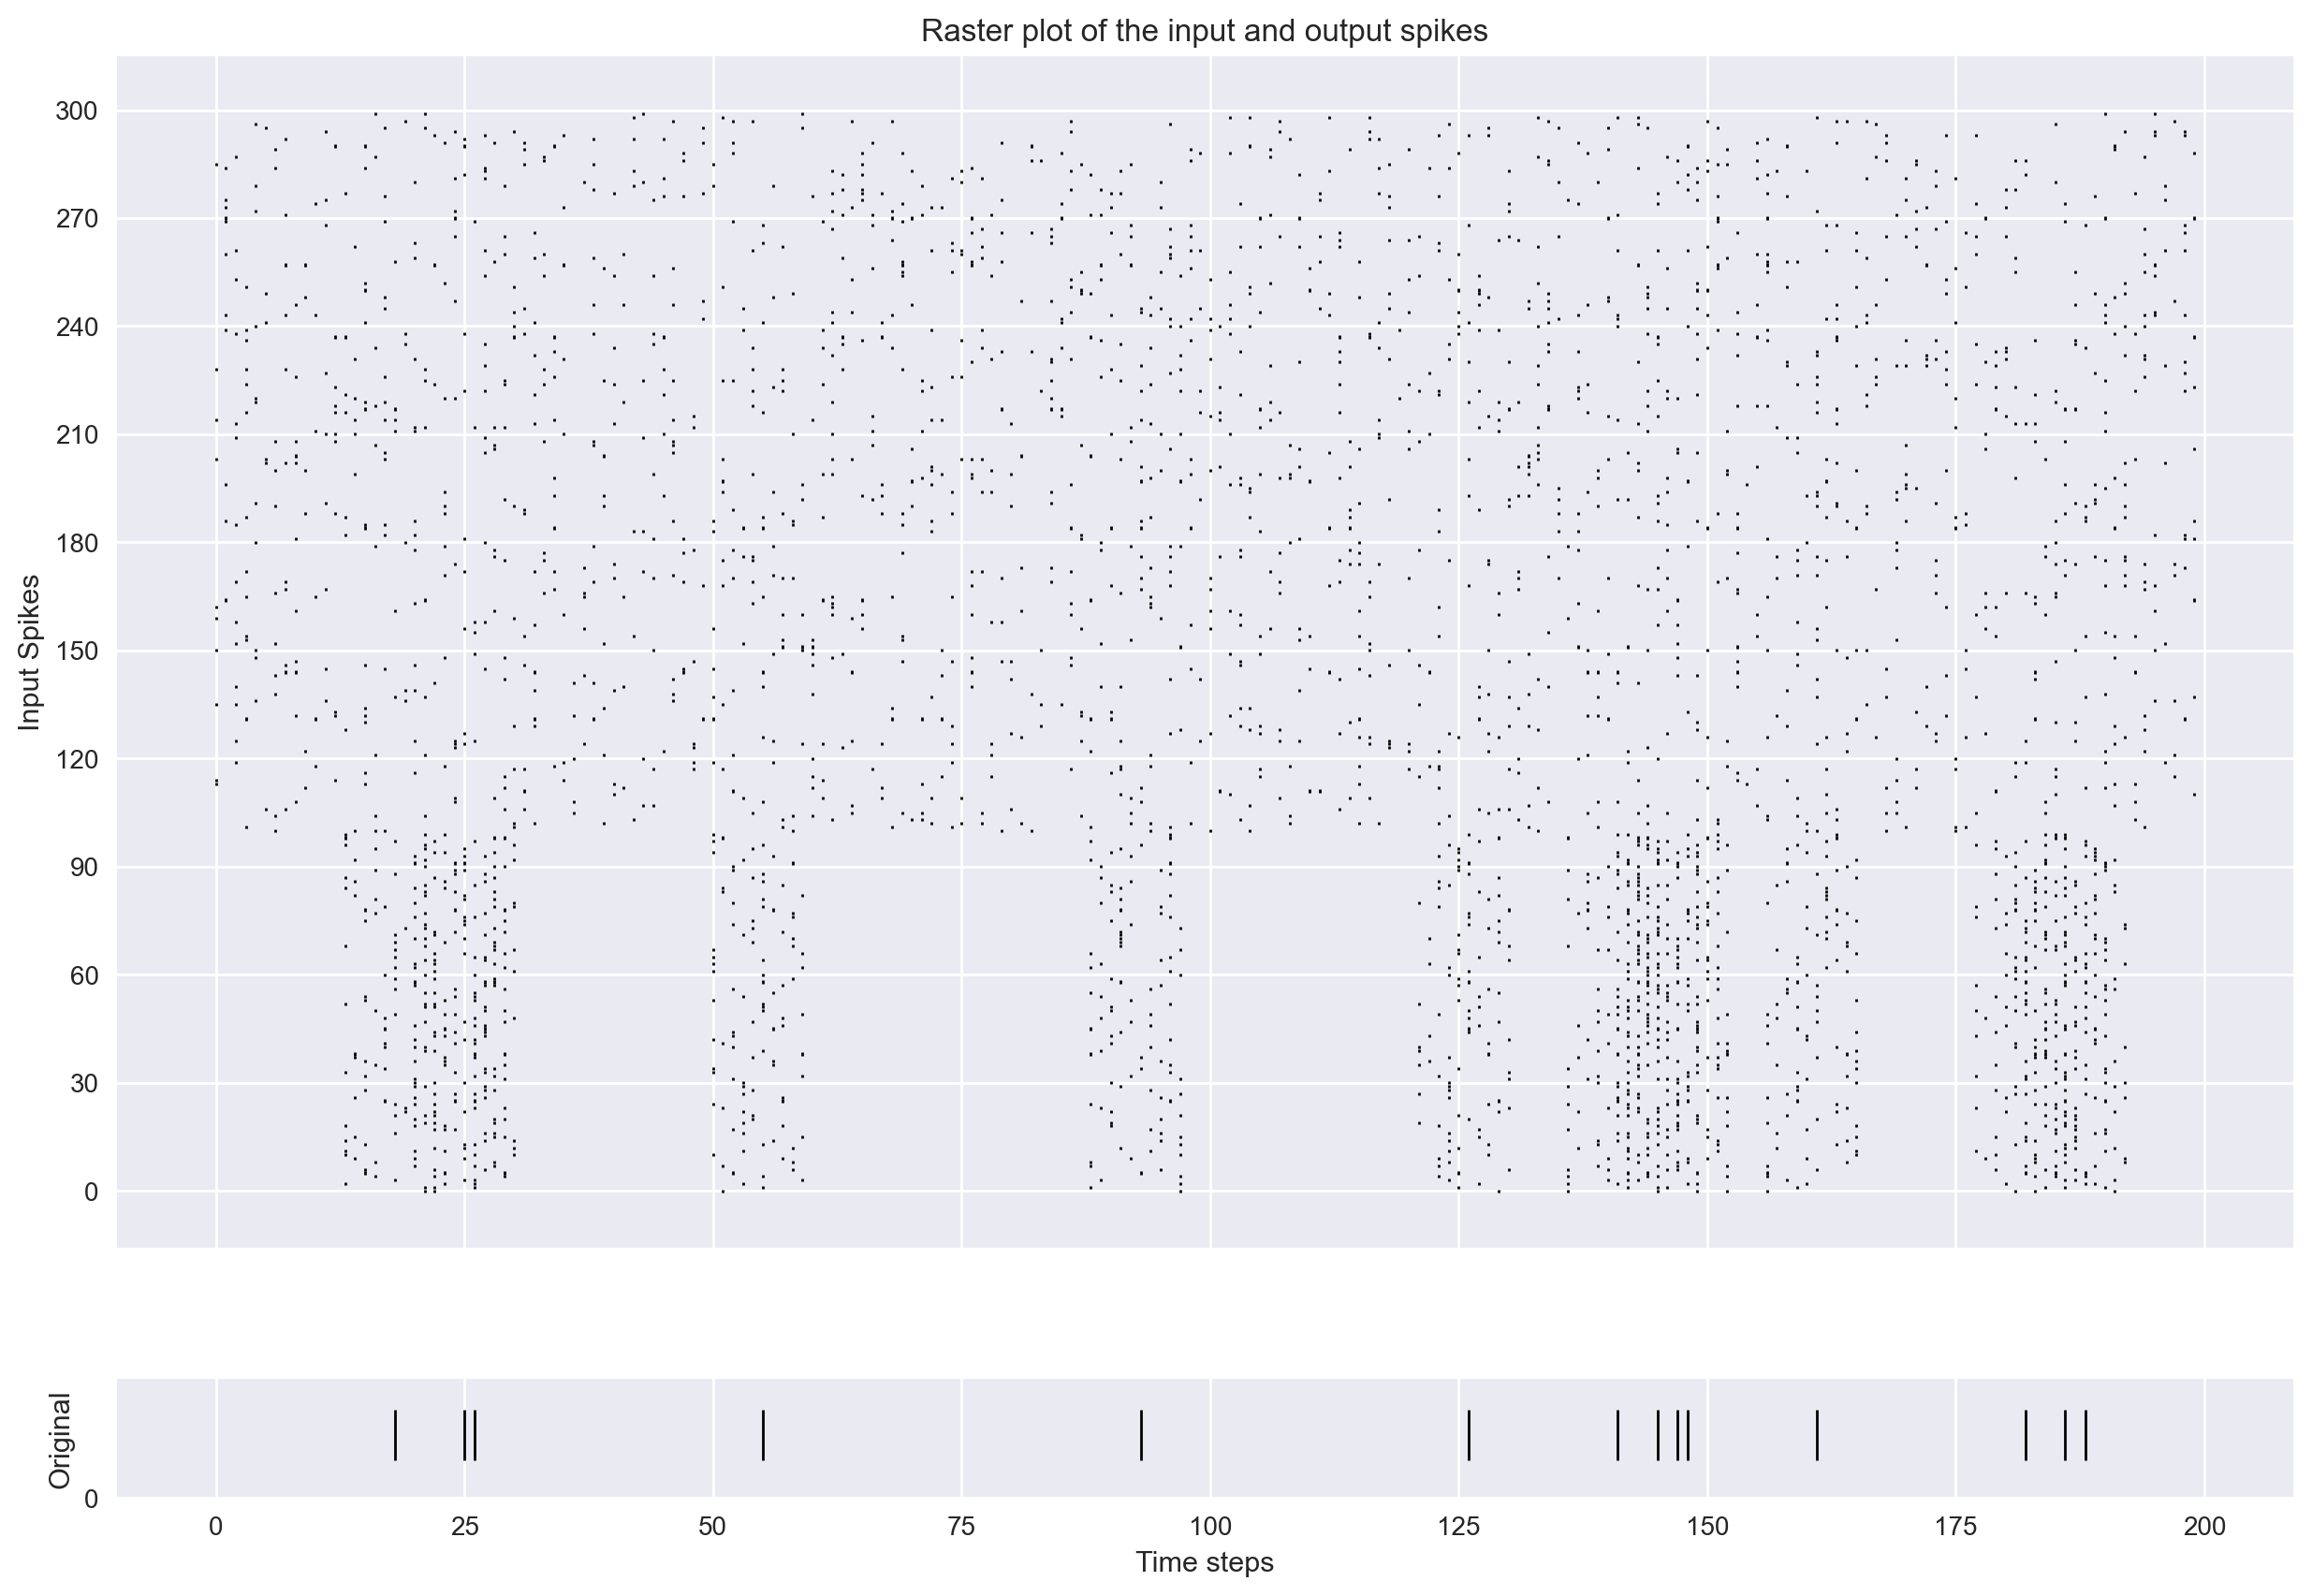

In [9]:
N_pre = 300
N_pre_correlated = 100
num_steps = 200
N_post = 1
shift = 5
type_parameters = 'simple'
type_parameters = 'realistic'
pars = default_pars(type_parameters=type_parameters)
dt = pars['dt']
rate = 0.05

I_perturbed, original = random_shifted_trains(dt, num_steps , N_pre, N_pre_correlated  , shift_values = [-shift,shift], rate = rate, my_seed  = False)

raster_plot(pars, pre_syn_spk=I_perturbed, post_syn_spk=original, title = 'Raster plot of the input and output spikes', y_2_label = 'Original')


In [10]:
interactive_demo_1 = STDP_interactive_plot(
    pars_function = default_pars, 
    type_parameters = 'realistic',
    I=I_perturbed, 
    N_post = 1,
    manual_update = True, 
    highlight = [i for i in range(N_pre_correlated)]
)

display(interactive_demo_1)

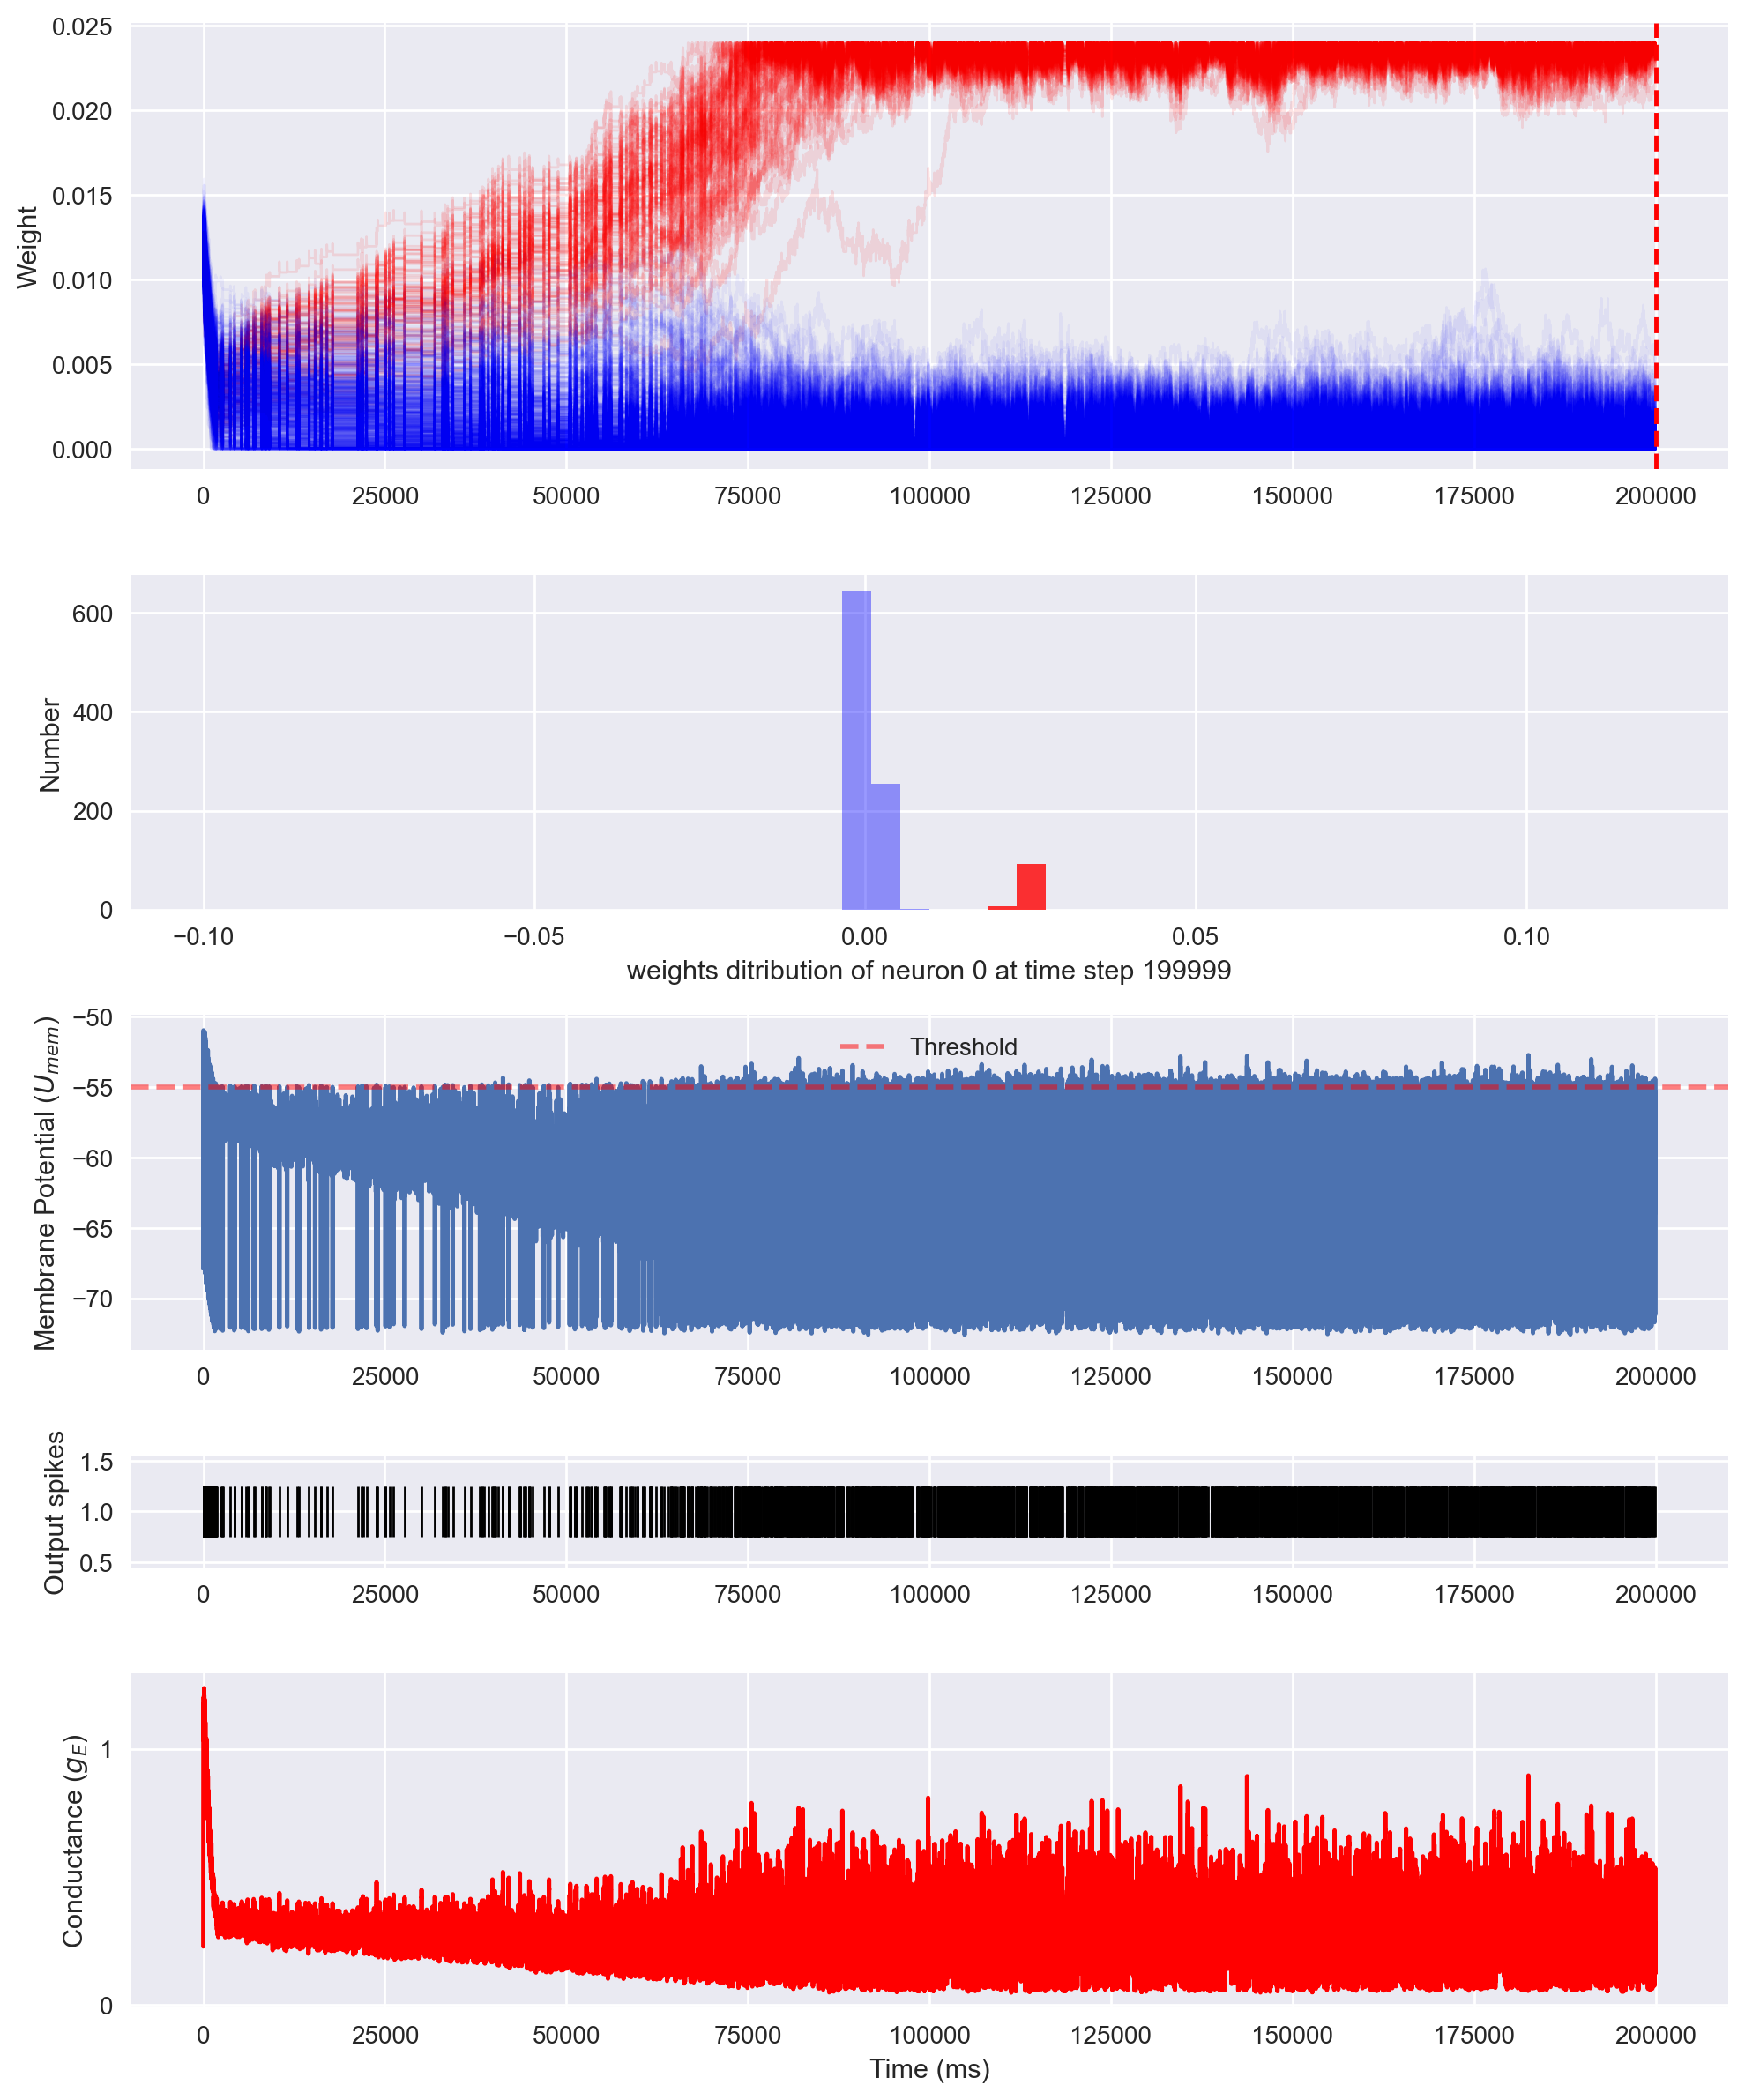

In [11]:
N_pre = 1000
N_pre_correlated = 100
num_steps = 200000
time_step = num_steps-1
N_post = 1
shift = 10
#type_parameters = 'simple'
type_parameters = 'realistic'
pars = default_pars(type_parameters=type_parameters, dt = 1, max_g = 0.024, )
dt = pars['dt']
time_steps = np.arange(0, num_steps, 1)
rate = 0.1

I_perturbed, original = random_shifted_trains(dt, num_steps , N_pre, N_pre_correlated  , shift_values = [-shift,shift], rate = rate, my_seed  = False)

W_init = np.ones((N_post, N_pre)) * pars['w_init_value'] 

neurons, syn = simulation(pars, I_perturbed, neuron_type = LIF_syn_conductance, weight_rule = STDP_synapse, N_post = N_post, W_init = W_init)

post_index=0
selected_neuron = neurons[post_index]

post_spk_train = selected_neuron.get_records()['spk']
mem = selected_neuron.get_records()['mem']
if selected_neuron.dynamic_threshold:
    thr_records = selected_neuron.get_records()['thr']

weights_history = syn.get_records()['W']

s = 1 # subsampling seems not be usefull

height_ratios = [4, 3, 3, 1, 3]
fig,ax = plt.subplots(5, figsize=(10, 12), gridspec_kw={'height_ratios': height_ratios})#, sharex=True)

# plot the weights
highlight = [i for i in range(N_pre_correlated)]
x = time_steps[::s]
y = weights_history[1 ::s,post_index,:]
if len(highlight) > 0:
    alpha = 1/(N_pre-len(highlight)) + 0.05
    alpha1 = alpha/N_pre * len(highlight) + 0.1
    alpha2 = alpha/N_pre * (N_pre-len(highlight))
    mask = np.isin(np.arange(N_pre), highlight)
    df1 = pd.DataFrame(y[:,mask])
    df1.plot(ax=ax[0], color = 'r', lw=1., alpha=alpha1, legend=False)
    df2 = pd.DataFrame(y[:,~mask])
    df2.plot(ax=ax[0], color = 'b', lw=1., alpha=alpha2, legend=False)
else:
    ax[0].plot(x, y, lw=1.)
ax[0].axvline(time_step, 0., 1., color='red', ls='--')
if pars['constrain'] == 'Dynamic':
    ax[0].axhline(syn.w_max, 0., 1., color='green', ls='--')
    ax[0].axhline(syn.w_min, 0., 1., color='green', ls='--')
ax[0].set_ylabel('Weight')


# plot the weights distribution
w_min = np.min(weights_history[time_step,:])-0.1
w_max = np.max(weights_history[time_step,:])+0.1
width = (w_max - w_min)/51
bins = np.arange(w_min, w_max, width)
if len(highlight) > 0:
    ax[1].hist(weights_history[time_step,post_index,mask], bins, color='r', alpha=0.8,  linewidth=0.5)
    ax[1].hist(weights_history[time_step,post_index,~mask], bins, color='b', alpha=0.4, linewidth=0.5)
else:
    ax[1].hist(weights_history[time_step,post_index,:], bins, color='b', alpha=0.5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
ax[1].set_xlabel(f'weights ditribution of neuron {post_index} at time step {time_step}')
ax[1].set_ylabel('Number')
#ax[1].set_title(f'Time step: {time_step}')

# plot the membrane potential
ax[2].plot(time_steps, mem)
ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
if selected_neuron.dynamic_threshold:
    ax[2].plot(time_steps, thr_records, c="red", linestyle="dashed", alpha=0.7, label="Threshold")
else:
    ax[2].axhline(y=selected_neuron.threshold, alpha=0.5, linestyle="dashed", c="red", linewidth=2, label="Threshold")
ax[2].legend( loc="best")

# plot the spikes
ax[3].eventplot(np.array(np.where(post_spk_train==1))*dt, color="black", linelengths=0.5, linewidths=1)
ax[3].set_xlim(ax[0].get_xlim())
ax[3].set_ylabel("Output spikes")
plt.yticks([])

# plot selected postsynaptic neuron conductance
g = selected_neuron.get_records()['g_E']
ax[4].plot(time_steps, g, color='red')
ax[4].set_ylabel("Conductance ($g_E$)")
# add y ticks
ax[4].set_yticks([0, 1])
ax[4].set_xlabel("Time (ms)")


plt.tight_layout()
plt.show()

## Latency Reduction

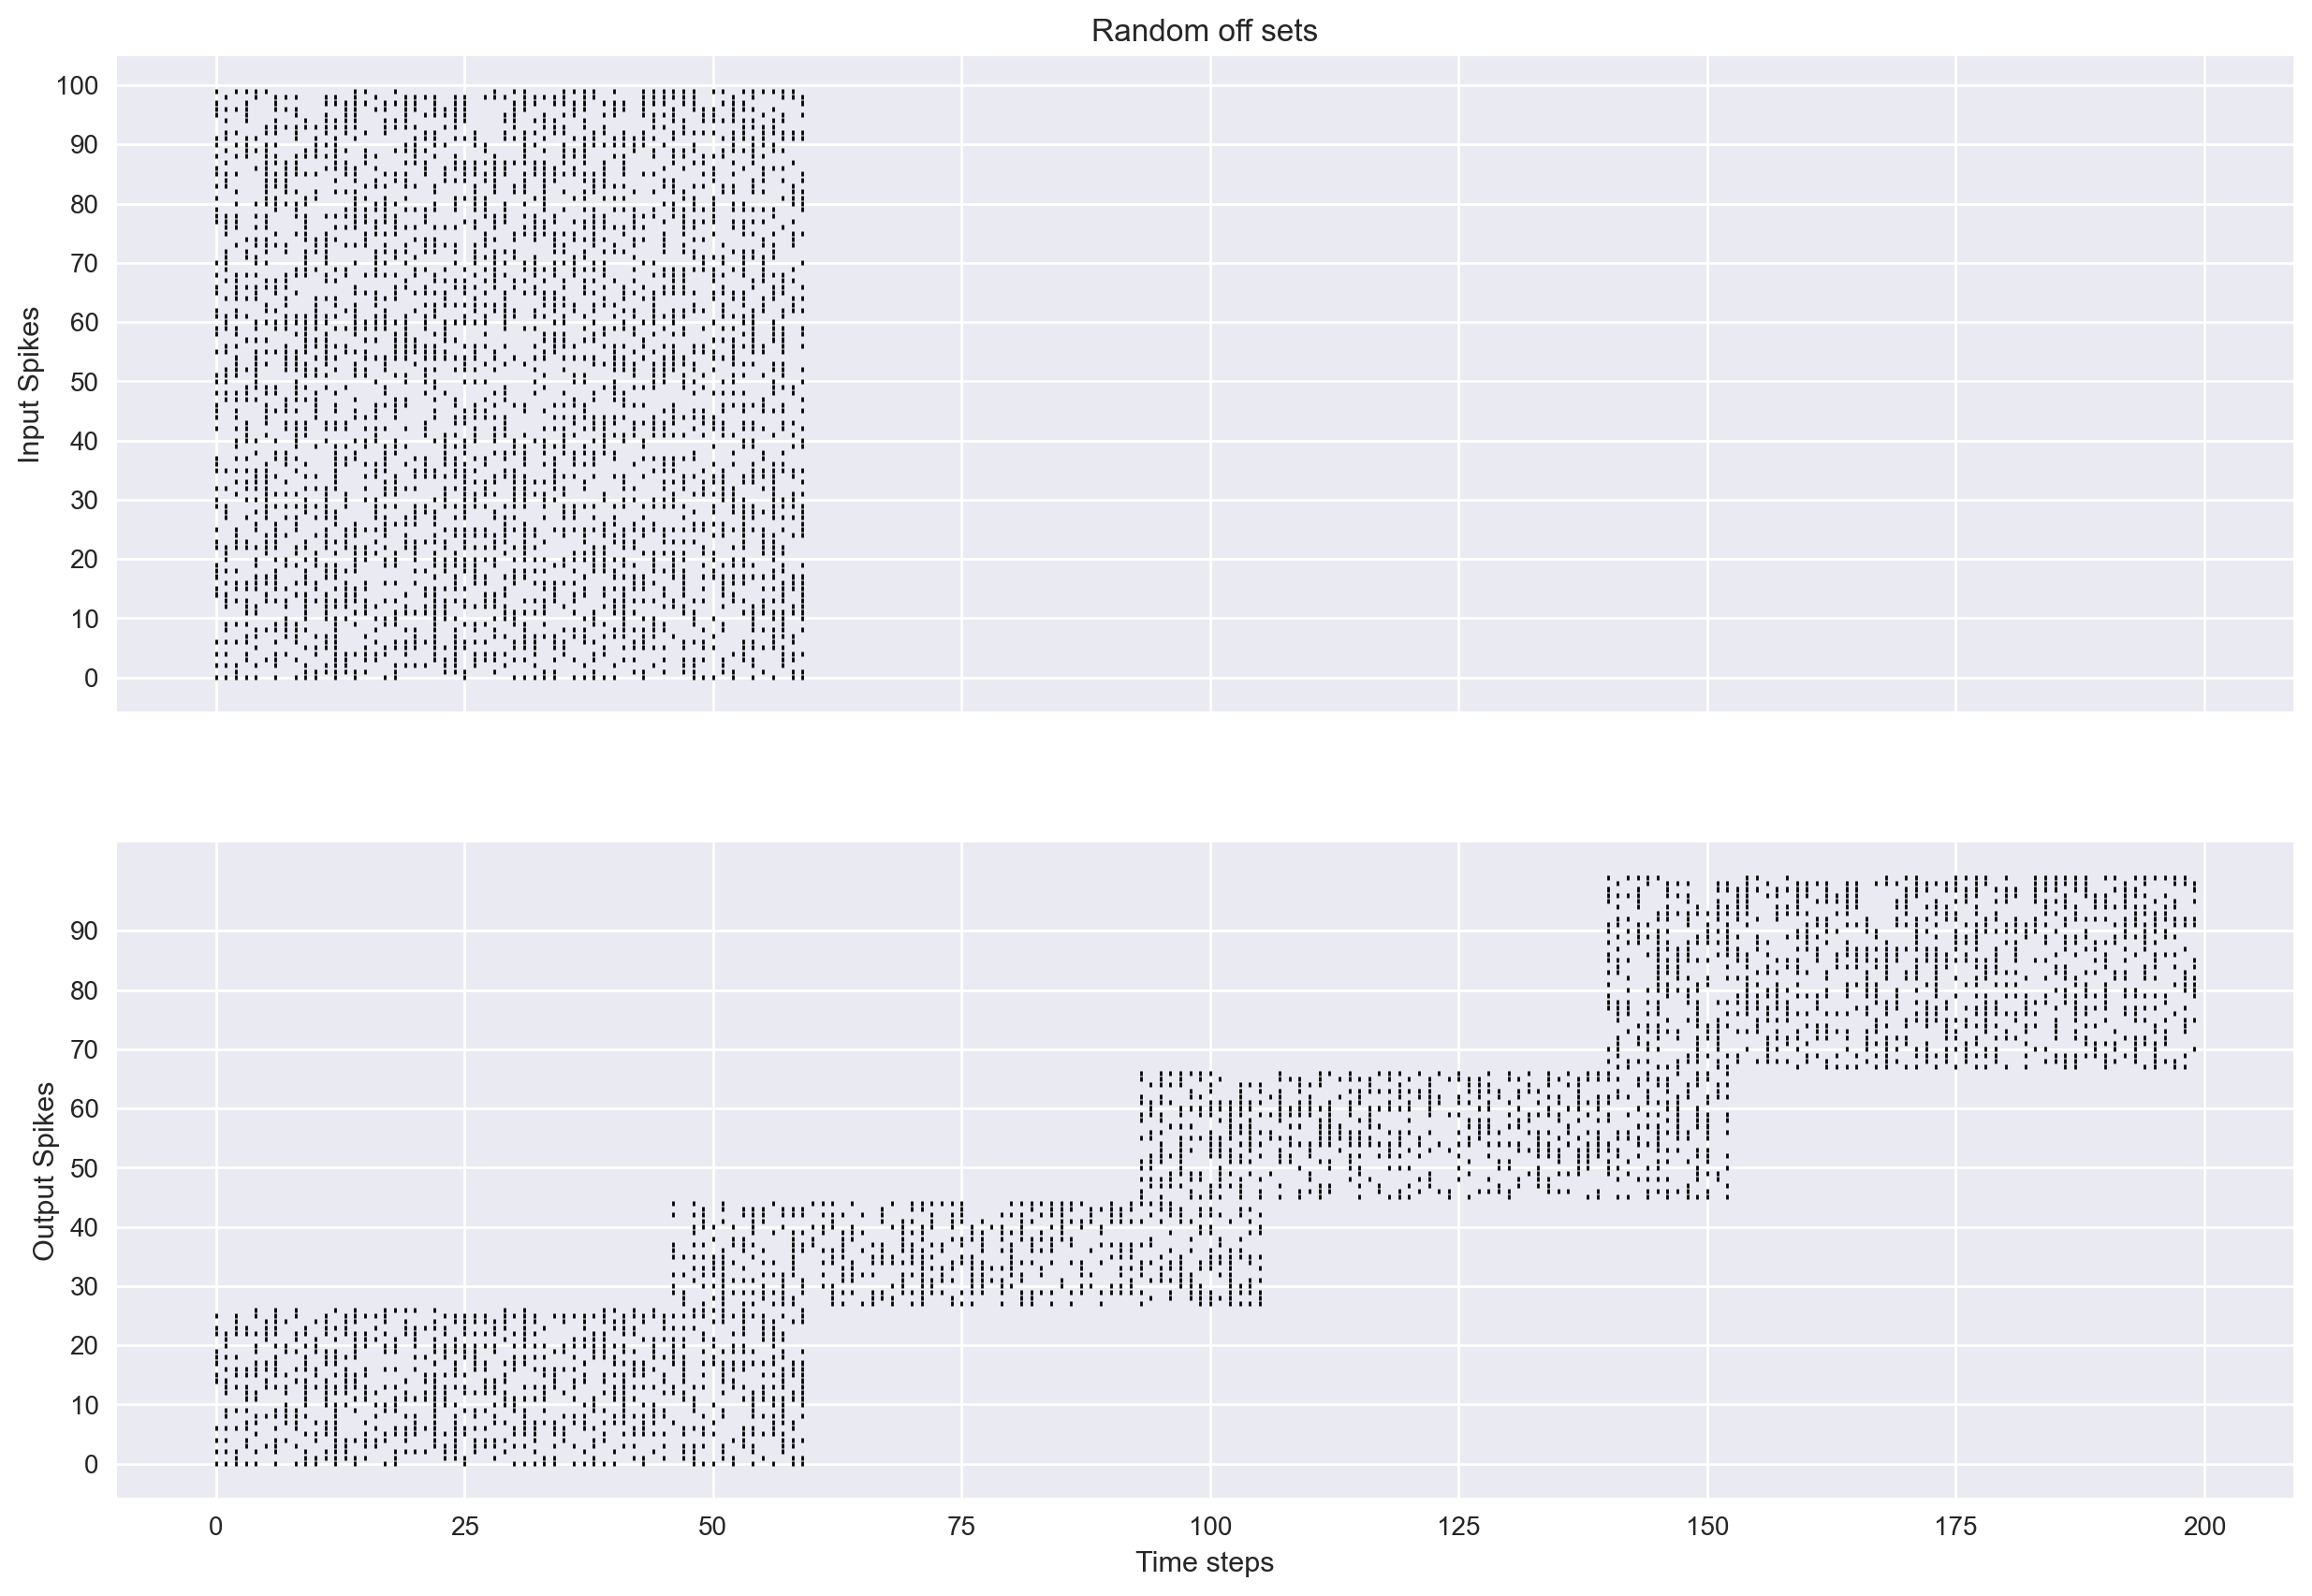

In [12]:
N_pre = 100
num_steps = 200
N_post = 1
N_pre = 100

pars = default_pars( A_plus = 0.7, A_minus = 1, tau_plus = 20, tau_minus = 20, w_max = 10, w_min = 0.001, R = 10, dynamic_weight_exponent = 0.2)
dt = pars['dt']

I_shifted,I_original , first_section_index = random_offsets(dt, num_steps, N_pre, rate = 0.5, sections = 4, sort_shifts = True, length_ratio = 0.3)

raster_plot(pars['dt'], pre_syn_spk = I_original, post_syn_spk = I_shifted, title='Random off sets')

In [13]:
neuron_params = {'refractory_time': False, 'dynamic_threshold': True, 'hard_reset':True}
weight_update_params = {'short_memory_trace':False, 'constrain':'None'}
interactive_demo_2 = STDP_interactive_plot(pars_function = default_pars, I=I_shifted, N_post = 1,
                                        manual_update = False, 
                                        highlight = first_section_index 
                                        )
display(interactive_demo_2)

In [14]:
# interactive_demo_2.close()

## Pattern start detection

array([[1., 1., 1., 0., 0., 0., 0., 1., 1., 0.]])

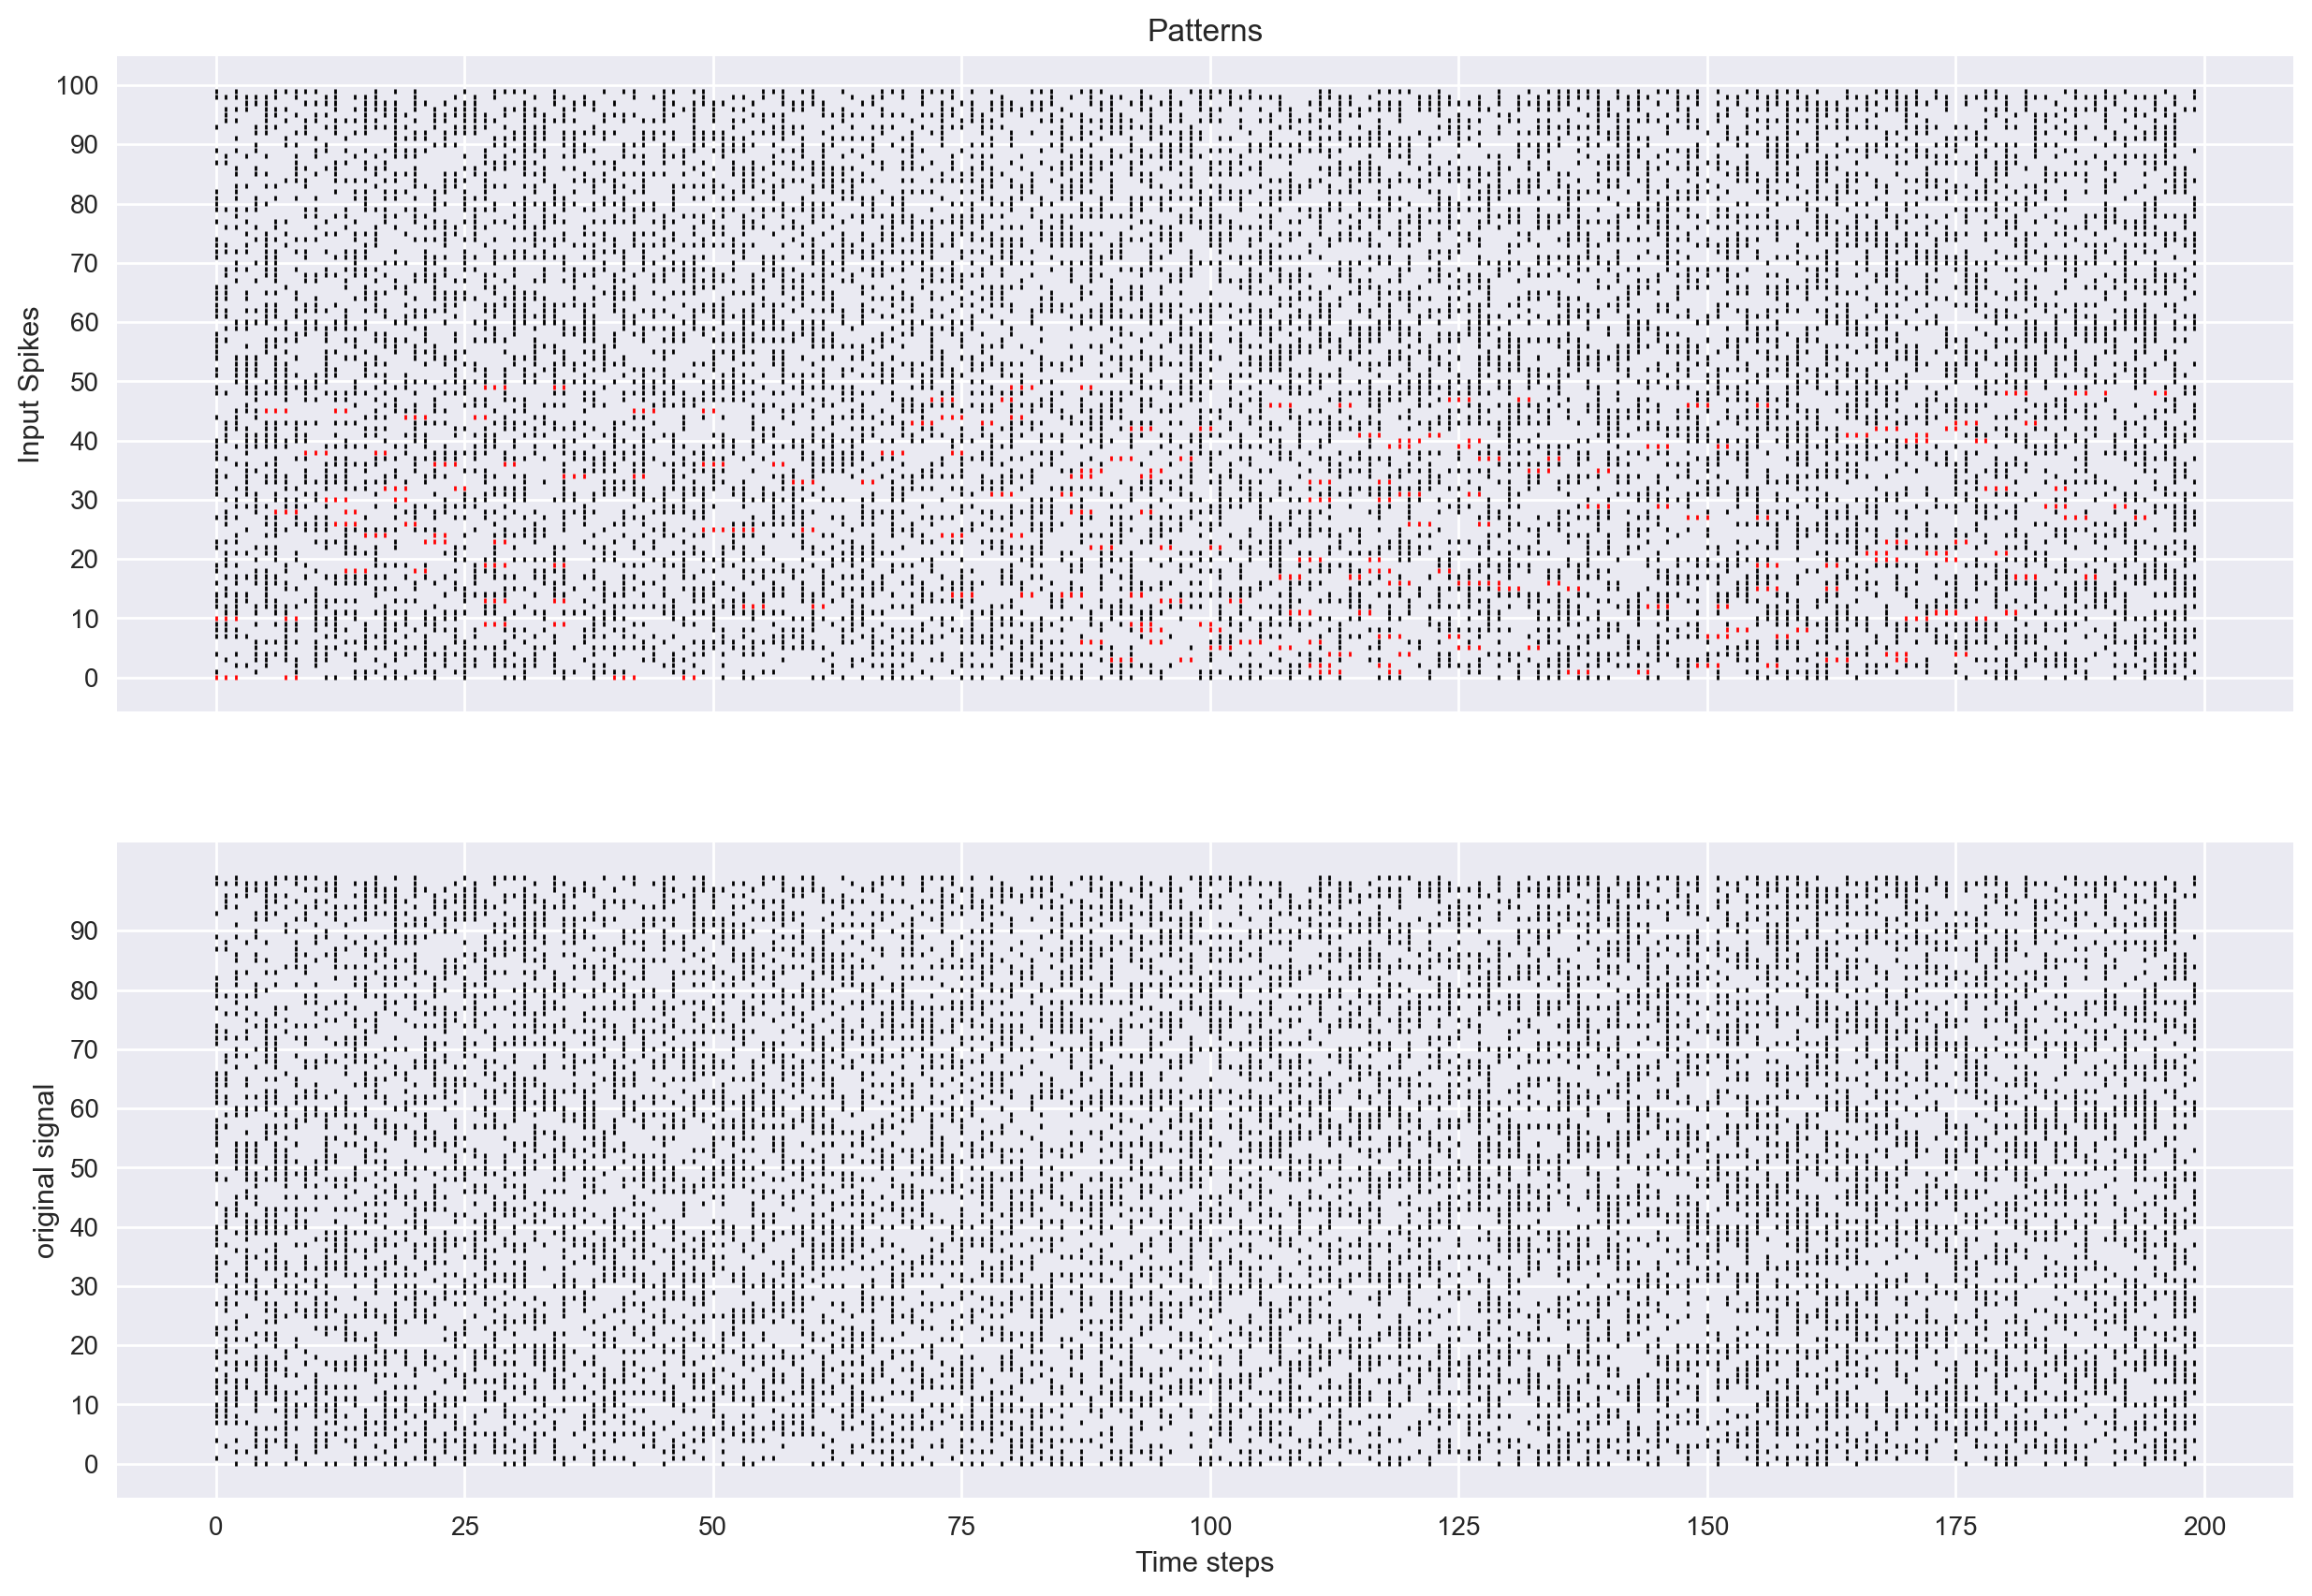

In [15]:
N_pre = 100
num_steps = 200
N_post = 1
ratio_with_pattern = 0.5
pars = default_pars( A_plus = 0.7, A_minus = 1, tau_plus = 20, tau_minus = 20, w_max = 10, w_min = 0.001, R = 10, dynamic_weight_exponent = 0.2)
dt = pars['dt']

I_original,  I_perturbed, correlated_indexes, perturbation_sites = signals_with_patterns(dt , N_pre, num_steps, repeats = 2, 
                                                                                         ratio_with_pattern=ratio_with_pattern,
                                                                                         display_pattern = True)

raster_plot(pars['dt'], pre_syn_spk = I_perturbed, post_syn_spk = I_original, title='Patterns', y_2_label = 'original signal', perturbation_sites=perturbation_sites)

In [16]:
neuron_params = {'refractory_time': False, 'dynamic_threshold': True, 'hard_reset':True}
weight_update_params = {'short_memory_trace':False, 'constrain':'None'}
interactive_demo_3 = STDP_interactive_plot(pars_function = default_pars, I=I_perturbed, N_post = N_post,
                                        manual_update = False, 
                                        highlight = correlated_indexes
                                        )

display(interactive_demo_3)